# Analysis final gaze processing


This code was developed and written by Jasmin L. Walter

In [288]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Preprocessing

## import

In [3]:
## optimizationimport copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [4]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [5]:
data_savepath_resampled = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step2_resampling"


data_savepath_intermediateP = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing"

data_savepath_plots= "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/gaze_processing_plots"



# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [47]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
PartList = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
# PartList = [1074, 1075, 1077, 1079, 1080]

print(len(PartList),'participants') 

26 participants



# Analysis

In [155]:
print('start')


gaze_lengths = pd.DataFrame()
saccade_lengths = pd.DataFrame()
noData_lengths = pd.DataFrame()

checkSmallGazeIndex = pd.DataFrame()


    
dataLength_overview = pd.DataFrame()



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    gaze_durations = []
    saccade_durations = []
    noD_durations = []
    fix_NH_durations = []
    dataLength = []
    
    checkSmallGazeIndex_dur = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
            
            fix_length = data.loc[data['events'] == 2.0, 'length']
            sacc_length = data.loc[data['events'] == 1.0, 'length']
            noD_length =  data.loc[data['events'] == 3.0, 'length']
            
            # Filter to identify lengths smaller than 0.04 and save the indexes
            below_min_indexes = fix_length[fix_length < 0.04]
            
            gaze_durations.extend(fix_length)
            saccade_durations.extend(sacc_length)
            noD_durations.extend(noD_length)

            dataLength.append(len(data))  # Append to the list directly
            
            checkSmallGazeIndex_dur.extend(below_min_indexes)
    
    # Function to extend DataFrame with NaNs
    def extend_df(df, target_length):
        current_length = len(df)
        if current_length < target_length:
            additional_rows = target_length - current_length
            extra_df = pd.DataFrame({col: [float('nan')] * additional_rows for col in df.columns})
            df = pd.concat([df, extra_df], ignore_index=True)
        return df

    # Extend gaze_lengths DataFrame if necessary
    max_length_gaze = len(gaze_durations)
    gaze_lengths = extend_df(gaze_lengths, max_length_gaze)
    gaze_lengths[currentPart] = pd.Series(gaze_durations)

    # Extend saccade_lengths DataFrame if necessary
    max_length_saccade = len(saccade_durations)
    saccade_lengths = extend_df(saccade_lengths, max_length_saccade)
    saccade_lengths[currentPart] = pd.Series(saccade_durations)

    # Extend noData_lengths DataFrame if necessary
    max_length_noData = len(noD_durations)
    noData_lengths = extend_df(noData_lengths, max_length_noData)
    noData_lengths[currentPart] = pd.Series(noD_durations)

    # Extend dataLength_overview DataFrame if necessary
    max_length_dataLength = len(dataLength)
    dataLength_overview = extend_df(dataLength_overview, max_length_dataLength)
    dataLength_overview[currentPart] = pd.Series(dataLength)

    
    # Extend gaze_lengths DataFrame if necessary
    max_length_ind = len(checkSmallGazeIndex_dur)
    gcheckSmallGazeIndex = extend_df(checkSmallGazeIndex, max_length_ind)
    checkSmallGazeIndex[currentPart] = pd.Series(checkSmallGazeIndex_dur)
    



            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             gaze_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     gaze_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and gaze_start_time is not None:
#                     gaze_durations.append((row['timeStampDataPointStart_converted'] - gaze_start_time))
#                     gaze_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None# file and data length

start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv
process file  1004_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_processed_gazes.csv
process file  1004_Session_2_ET_2_data_processed_gazes.csv
process file  1004_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_processed_gazes.csv
process file  1004_Session_3_ET_2_data_processed_gazes.csv
process file  1004_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_processed_gazes.csv
process file  1004_Session_4_ET_2_data_processed_gazes.csv
process file  1004_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_processed_gazes.csv
process file  1004_Session_5_ET_2_data_processed_gazes.csv
process file  1004_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1005


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:147: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_processed_gazes.csv
process file  1005_Session_1_ET_2_data_processed_gazes.csv
process file  1005_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_processed_gazes.csv
process file  1005_Session_2_ET_2_data_processed_gazes.csv
process file  1005_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_processed_gazes.csv
process file  1005_Session_3_ET_2_data_processed_gazes.csv
process file  1005_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_processed_gazes.csv
process file  1005_Session_4_ET_2_data_processed_gazes.csv
process file  1005_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_processed_gazes.csv
process file  1005_Session_5_ET_2_data_processed_gazes.csv
process file  1005_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_processed_gazes.csv
process file  1008_Session_1_ET_2_data_processed_gazes.csv
process file  1008_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_processed_gazes.csv
process file  1008_Session_2_ET_2_data_processed_gazes.csv
process file  1008_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_processed_gazes.csv
process file  1008_Session_3_ET_2_data_processed_gazes.csv
process file  1008_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_processed_gazes.csv
process file  1008_Session_4_ET_2_data_processed_gazes.csv
process file  1008_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_processed_gazes.csv
process file  1008_Session_5_ET_2_data_processed_gazes.csv
process file  1008_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_processed_gazes.csv
process file  1010_Session_1_ET_2_data_processed_gazes.csv
process file  1010_Session_1_ET_3_data_processed_gazes.csv
process file  1010_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_processed_gazes.csv
process file  1010_Session_2_ET_2_data_processed_gazes.csv
process file  1010_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_processed_gazes.csv
process file  1010_Session_3_ET_2_data_processed_gazes.csv
process file  1010_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_processed_gazes.csv
process file  1010_Session_4_ET_2_data_processed_gazes.csv
process file  1010_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_processed_gazes.csv
process file  1010_Session_5_ET_2_data_processed_gazes.csv
process file  1010_Session_5_ET_3_data_processed_gazes.csv
process file  1010_Session_5_ET_4_data_processed_gazes.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_processed_gazes.csv
process file  1011_Session_1_ET_2_data_processed_gazes.csv
process file  1011_Session_1_ET_3_data_processed_gazes.csv
process file  1011_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_processed_gazes.csv
process file  1011_Session_2_ET_2_data_processed_gazes.csv
process file  1011_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_processed_gazes.csv
process file  1011_Session_3_ET_2_data_processed_gazes.csv
process file  1011_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_processed_gazes.csv
process file  1011_Session_4_ET_2_data_processed_gazes.csv
process file  1011_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_processed_gazes.csv
process file  1011_Session_5_ET_2_data_processed_gazes.csv
process file  1011_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_processed_gazes.csv
process file  1013_Session_1_ET_2_data_processed_gazes.csv
process file  1013_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_processed_gazes.csv
process file  1013_Session_2_ET_2_data_processed_gazes.csv
process file  1013_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_processed_gazes.csv
process file  1013_Session_3_ET_2_data_processed_gazes.csv
process file  1013_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_processed_gazes.csv
process file  1013_Session_4_ET_2_data_processed_gazes.csv
process file  1013_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_processed_gazes.csv
process file  1013_Session_5_ET_2_data_processed_gazes.csv
process file  1013_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_processed_gazes.csv
process file  1017_Session_1_ET_2_data_processed_gazes.csv
process file  1017_Session_1_ET_3_data_processed_gazes.csv
process file  1017_Session_1_ET_4_data_processed_gazes.csv
process file  1017_Session_1_ET_5_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_processed_gazes.csv
process file  1017_Session_2_ET_2_data_processed_gazes.csv
process file  1017_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_processed_gazes.csv
process file  1017_Session_3_ET_2_data_processed_gazes.csv
process file  1017_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_processed_gazes.csv
process file  1017_Session_4_ET_2_data_processed_gazes.csv
process file  1017_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_processed_gazes.csv
process file  1017_Session_5_ET_2_data_processed_gazes.csv
process file  1017_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_processed_gazes.csv
process file  1018_Session_1_ET_2_data_processed_gazes.csv
process file  1018_Session_1_ET_3_data_processed_gazes.csv
process file  1018_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_processed_gazes.csv
process file  1018_Session_2_ET_2_data_processed_gazes.csv
process file  1018_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_processed_gazes.csv
process file  1018_Session_3_ET_2_data_processed_gazes.csv
process file  1018_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_processed_gazes.csv
process file  1018_Session_4_ET_2_data_processed_gazes.csv
process file  1018_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_processed_gazes.csv
process file  1018_Session_5_ET_2_data_processed_gazes.csv
process file  1018_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_processed_gazes.csv
process file  1019_Session_1_ET_2_data_processed_gazes.csv
process file  1019_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_processed_gazes.csv
process file  1019_Session_2_ET_2_data_processed_gazes.csv
process file  1019_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_processed_gazes.csv
process file  1019_Session_3_ET_2_data_processed_gazes.csv
process file  1019_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_processed_gazes.csv
process file  1019_Session_4_ET_2_data_processed_gazes.csv
process file  1019_Session_4_ET_3_data_processed_gazes.csv
process file  1019_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_processed_gazes.csv
process file  1019_Session_5_ET_2_data_processed_gazes.csv
process file  1019_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_processed_gazes.csv
process file  1021_Session_1_ET_2_data_processed_gazes.csv
process file  1021_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_processed_gazes.csv
process file  1021_Session_2_ET_2_data_processed_gazes.csv
process file  1021_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_processed_gazes.csv
process file  1021_Session_3_ET_2_data_processed_gazes.csv
process file  1021_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_processed_gazes.csv
process file  1021_Session_4_ET_2_data_processed_gazes.csv
process file  1021_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_processed_gazes.csv
process file  1021_Session_5_ET_2_data_processed_gazes.csv
process file  1021_Session_5_ET_3_data_processed_gazes.csv
process file  1021_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_processed_gazes.csv
process file  1022_Session_1_ET_2_data_processed_gazes.csv
process file  1022_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_processed_gazes.csv
process file  1022_Session_2_ET_2_data_processed_gazes.csv
process file  1022_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_processed_gazes.csv
process file  1022_Session_3_ET_2_data_processed_gazes.csv
process file  1022_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_processed_gazes.csv
process file  1022_Session_4_ET_2_data_processed_gazes.csv
process file  1022_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_processed_gazes.csv
process file  1022_Session_5_ET_2_data_processed_gazes.csv
process file  1022_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_processed_gazes.csv
process file  1023_Session_1_ET_2_data_processed_gazes.csv
process file  1023_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_processed_gazes.csv
process file  1023_Session_2_ET_2_data_processed_gazes.csv
process file  1023_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_processed_gazes.csv
process file  1023_Session_3_ET_2_data_processed_gazes.csv
process file  1023_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_processed_gazes.csv
process file  1023_Session_4_ET_2_data_processed_gazes.csv
process file  1023_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_processed_gazes.csv
process file  1023_Session_5_ET_2_data_processed_gazes.csv
process file  1023_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_processed_gazes.csv
process file  1054_Session_1_ET_2_data_processed_gazes.csv
process file  1054_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_processed_gazes.csv
process file  1054_Session_2_ET_2_data_processed_gazes.csv
process file  1054_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_processed_gazes.csv
process file  1054_Session_3_ET_2_data_processed_gazes.csv
process file  1054_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_processed_gazes.csv
process file  1054_Session_4_ET_2_data_processed_gazes.csv
process file  1054_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_processed_gazes.csv
process file  1054_Session_5_ET_2_data_processed_gazes.csv
process file  1054_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_processed_gazes.csv
process file  1055_Session_1_ET_2_data_processed_gazes.csv
process file  1055_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_processed_gazes.csv
process file  1055_Session_2_ET_2_data_processed_gazes.csv
process file  1055_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_processed_gazes.csv
process file  1055_Session_3_ET_2_data_processed_gazes.csv
process file  1055_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_processed_gazes.csv
process file  1055_Session_4_ET_2_data_processed_gazes.csv
process file  1055_Session_4_ET_3_data_processed_gazes.csv
process file  1055_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_processed_gazes.csv
process file  1055_Session_5_ET_2_data_processed_gazes.csv
process file  1055_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_processed_gazes.csv
process file  1056_Session_1_ET_2_data_processed_gazes.csv
process file  1056_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_processed_gazes.csv
process file  1056_Session_2_ET_2_data_processed_gazes.csv
process file  1056_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_processed_gazes.csv
process file  1056_Session_3_ET_2_data_processed_gazes.csv
process file  1056_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_processed_gazes.csv
process file  1056_Session_4_ET_2_data_processed_gazes.csv
process file  1056_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_processed_gazes.csv
process file  1056_Session_5_ET_2_data_processed_gazes.csv
process file  1056_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_processed_gazes.csv
process file  1057_Session_1_ET_2_data_processed_gazes.csv
process file  1057_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_processed_gazes.csv
process file  1057_Session_2_ET_2_data_processed_gazes.csv
process file  1057_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_processed_gazes.csv
process file  1057_Session_3_ET_2_data_processed_gazes.csv
process file  1057_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_processed_gazes.csv
process file  1057_Session_4_ET_2_data_processed_gazes.csv
process file  1057_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_processed_gazes.csv
process file  1057_Session_5_ET_2_data_processed_gazes.csv
process file  1057_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_processed_gazes.csv
process file  1058_Session_1_ET_2_data_processed_gazes.csv
process file  1058_Session_1_ET_3_data_processed_gazes.csv
process file  1058_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_processed_gazes.csv
process file  1058_Session_2_ET_2_data_processed_gazes.csv
process file  1058_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_processed_gazes.csv
process file  1058_Session_3_ET_2_data_processed_gazes.csv
process file  1058_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_processed_gazes.csv
process file  1058_Session_4_ET_2_data_processed_gazes.csv
process file  1058_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_processed_gazes.csv
process file  1058_Session_5_ET_2_data_processed_gazes.csv
process file  1058_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_processed_gazes.csv
process file  1068_Session_1_ET_2_data_processed_gazes.csv
process file  1068_Session_1_ET_3_data_processed_gazes.csv
process file  1068_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_processed_gazes.csv
process file  1068_Session_2_ET_2_data_processed_gazes.csv
process file  1068_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_processed_gazes.csv
process file  1068_Session_3_ET_2_data_processed_gazes.csv
process file  1068_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_processed_gazes.csv
process file  1068_Session_4_ET_2_data_processed_gazes.csv
process file  1068_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_processed_gazes.csv
process file  1068_Session_5_ET_2_data_processed_gazes.csv
process file  1068_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_processed_gazes.csv
process file  1069_Session_1_ET_2_data_processed_gazes.csv
process file  1069_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_processed_gazes.csv
process file  1069_Session_2_ET_2_data_processed_gazes.csv
process file  1069_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_processed_gazes.csv
process file  1069_Session_3_ET_2_data_processed_gazes.csv
process file  1069_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_processed_gazes.csv
process file  1069_Session_4_ET_2_data_processed_gazes.csv
process file  1069_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_processed_gazes.csv
process file  1069_Session_5_ET_2_data_processed_gazes.csv
process file  1069_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_processed_gazes.csv
process file  1072_Session_1_ET_2_data_processed_gazes.csv
process file  1072_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_processed_gazes.csv
process file  1072_Session_2_ET_2_data_processed_gazes.csv
process file  1072_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_processed_gazes.csv
process file  1072_Session_3_ET_2_data_processed_gazes.csv
process file  1072_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_processed_gazes.csv
process file  1072_Session_4_ET_2_data_processed_gazes.csv
process file  1072_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_processed_gazes.csv
process file  1072_Session_5_ET_2_data_processed_gazes.csv
process file  1072_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_processed_gazes.csv
process file  1073_Session_1_ET_2_data_processed_gazes.csv
process file  1073_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_processed_gazes.csv
process file  1073_Session_2_ET_2_data_processed_gazes.csv
process file  1073_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_processed_gazes.csv
process file  1073_Session_3_ET_2_data_processed_gazes.csv
process file  1073_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_processed_gazes.csv
process file  1073_Session_4_ET_2_data_processed_gazes.csv
process file  1073_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_processed_gazes.csv
process file  1073_Session_5_ET_2_data_processed_gazes.csv
process file  1073_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_processed_gazes.csv
process file  1074_Session_1_ET_2_data_processed_gazes.csv
process file  1074_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_processed_gazes.csv
process file  1074_Session_2_ET_2_data_processed_gazes.csv
process file  1074_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_processed_gazes.csv
process file  1074_Session_3_ET_2_data_processed_gazes.csv
process file  1074_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_processed_gazes.csv
process file  1074_Session_4_ET_2_data_processed_gazes.csv
process file  1074_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_processed_gazes.csv
process file  1074_Session_5_ET_2_data_processed_gazes.csv
process file  1074_Session_5_ET_3_data_processed_gazes.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_processed_gazes.csv
process file  1075_Session_1_ET_2_data_processed_gazes.csv
process file  1075_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_processed_gazes.csv
process file  1075_Session_2_ET_2_data_processed_gazes.csv
process file  1075_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_processed_gazes.csv
process file  1075_Session_3_ET_2_data_processed_gazes.csv
process file  1075_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_processed_gazes.csv
process file  1075_Session_4_ET_2_data_processed_gazes.csv
process file  1075_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_processed_gazes.csv
process file  1075_Session_5_ET_2_data_processed_gazes.csv
process file  1075_Session_5_ET_3_data_processed_gazes.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_processed_gazes.csv
process file  1077_Session_1_ET_2_data_processed_gazes.csv
process file  1077_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_processed_gazes.csv
process file  1077_Session_2_ET_2_data_processed_gazes.csv
process file  1077_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_processed_gazes.csv
process file  1077_Session_3_ET_2_data_processed_gazes.csv
process file  1077_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_processed_gazes.csv
process file  1077_Session_4_ET_2_data_processed_gazes.csv
process file  1077_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_processed_gazes.csv
process file  1077_Session_5_ET_2_data_processed_gazes.csv
process file  1077_Session_5_ET_3_data_processed_gazes.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_processed_gazes.csv
process file  1079_Session_1_ET_2_data_processed_gazes.csv
process file  1079_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_processed_gazes.csv
process file  1079_Session_2_ET_2_data_processed_gazes.csv
process file  1079_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_processed_gazes.csv
process file  1079_Session_3_ET_2_data_processed_gazes.csv
process file  1079_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_processed_gazes.csv
process file  1079_Session_4_ET_2_data_processed_gazes.csv
process file  1079_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_processed_gazes.csv
process file  1079_Session_5_ET_2_data_processed_gazes.csv
process file  1079_Session_5_ET_3_data_processed_gazes.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_processed_gazes.csv
process file  1080_Session_1_ET_2_data_processed_gazes.csv
process file  1080_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_processed_gazes.csv
process file  1080_Session_2_ET_2_data_processed_gazes.csv
process file  1080_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_processed_gazes.csv
process file  1080_Session_3_ET_2_data_processed_gazes.csv
process file  1080_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_processed_gazes.csv
process file  1080_Session_4_ET_2_data_processed_gazes.csv
process file  1080_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_processed_gazes.csv
process file  1080_Session_5_ET_2_data_processed_gazes.csv
process file  1080_Session_5_ET_3_data_processed_gazes.csv


In [189]:
file= "1008_Session_5_ET_3_data_processed_gazes.csv"
data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
data.head()


fix_length = data.loc[data['events'] == 2.0, 'length']
sacc_length = data.loc[data['events'] == 1.0, 'length']
noD_length =  data.loc[data['events'] == 3.0, 'length']

# Filter to identify lengths smaller than 0.04 and save the indexes
below_min_indexes = fix_length[fix_length < 0.04]

len(below_min_indexes)

0

In [183]:
session 1 - et2
sessopm 4, et3

SyntaxError: invalid syntax (<ipython-input-183-c54ab3b536ac>, line 1)

In [165]:
fix_length[1]

0.0111111111111111

# file and data length

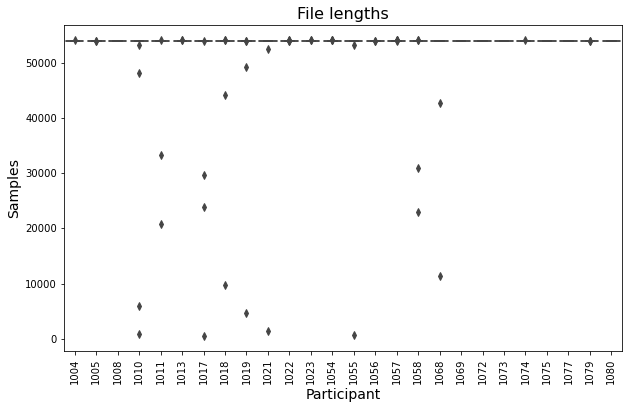

In [294]:
# dataLength_overview.sum()

dataLength_long_format = dataLength_overview.melt(var_name='Participant', value_name='Samples')


plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Samples', data=dataLength_long_format)
#
# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.title('File lengths', fontsize=16)

# # Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.show()

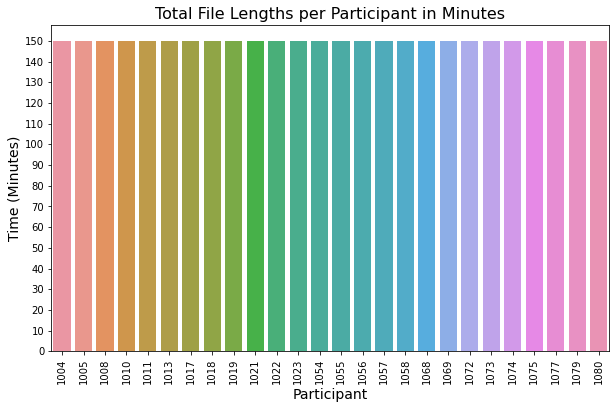

In [295]:

# Assuming dataLength_overview is your original DataFrame
fullData = dataLength_overview.sum()

# Convert the Series directly to a DataFrame
fullData_df = pd.DataFrame(fullData).reset_index()
fullData_df.columns = ['Participant', 'Samples']

# Calculate the corresponding time in minutes
fullData_df['Minutes'] = fullData_df['Samples'] / 5400  # 90 samples/sec * 60 sec/min

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each participant showing their summed samples
sns.barplot(x='Participant', y='Minutes', data=fullData_df)

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Time (Minutes)', fontsize=14)
plt.title('Total File Lengths per Participant in Minutes', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Update y-ticks to show corresponding minutes
new_yticks = np.arange(0, fullData_df['Minutes'].max(), step=10)  # Adjust step as needed
plt.yticks(new_yticks)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'TotalFileLength_parts_min_calc1.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()


In [241]:
print('start')


dataLength_step1_overview = pd.DataFrame()
fileCountOverview = pd.DataFrame(columns=['Participant', 'Session', 'FileCount'])

# Prepare to track missing files
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])

# Loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# Overall counter for files
overall_file_counts = {}

for indexPart, currentPart in enumerate(parts_pbar):
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1, 6))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
        
    # Loop over recording sessions
    for indexSess in session_pbar:
        # Get all eye tracking session files
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]

        # Track missing files
        if len(fileNames) < 3:  # Adjust this threshold as needed
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)

        # If files exist, process them
        if len(fileNames) > 0:
            session_file_count = 0  # Count files per session
            
            # Files progress bar
            file_pbar = tqdm(
                iterable=fileNames,
                total=len(fileNames),
                desc="📂 ET files____________",
                dynamic_ncols=True,
                bar_format=B_FORMAT,
            )

            for file_index, file in enumerate(file_pbar):
                print('process file ', file)

                # Read in data
                data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))

                # Length (number of rows) of the data
                row_count = len(data)

                # Assuming the duration per sample; adjust if your sample duration differs
                sample_duration = data['timeStampDataPointStart_converted'].iloc[-1]/60
                session_file_count += 1
                
                uncleanDataCount = (data['cleanData'] == 0).sum()

                uncleanDataPer = uncleanDataCount/len(data)
                
                fix_length = data.loc[data['events'] == 2.0, 'length']

                
                below_min = fix_length[fix_length < 0.04]
                if len(below_min)>0:
                    
                    below_min_index = fix_length[fix_length < 0.04].index == 1
                    below_min_index_1 = sum(below_min_index)
                else: 
                    below_min_index_1 = 0
                

                
                # Append the information to the overview DataFrame
                dataLength_step1_overview = dataLength_step1_overview.append({
                    'Participant': currentPart,
                    'Session': indexSess,
                    'ET': file_index,
                    'DataLength': row_count,
                    'SampleDuration': sample_duration,
                    'UncleanDataCount' : uncleanDataCount,
                    'uncleanDataPerc' : uncleanDataPer,
                    'NrGazes': len(fix_length),
                    'NrSmallGazes': len(below_min),
                    'below_min_index_1': below_min_index_1
                }, ignore_index=True)

            # Count the number of files processed for this participant and session
            fileCountOverview = fileCountOverview.append({
                'Participant': currentPart,
                'Session': indexSess,
                'FileCount': session_file_count
            }, ignore_index=True)
            
            # Keep a running total of files processed for each participant
            if currentPart in overall_file_counts:
                overall_file_counts[currentPart] += session_file_count
            else:
                overall_file_counts[currentPart] = session_file_count

# Optional: Convert overall file counts into a DataFrame for easier analysis
overall_file_count_df = pd.DataFrame(overall_file_counts.items(), columns=['Participant', 'TotalFileCount'])



start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv
process file  1004_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_processed_gazes.csv
process file  1004_Session_2_ET_2_data_processed_gazes.csv
process file  1004_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_processed_gazes.csv
process file  1004_Session_3_ET_2_data_processed_gazes.csv
process file  1004_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_processed_gazes.csv
process file  1004_Session_4_ET_2_data_processed_gazes.csv
process file  1004_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_processed_gazes.csv
process file  1004_Session_5_ET_2_data_processed_gazes.csv
process file  1004_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_processed_gazes.csv
process file  1005_Session_1_ET_2_data_processed_gazes.csv
process file  1005_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_processed_gazes.csv
process file  1005_Session_2_ET_2_data_processed_gazes.csv
process file  1005_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_processed_gazes.csv
process file  1005_Session_3_ET_2_data_processed_gazes.csv
process file  1005_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_processed_gazes.csv
process file  1005_Session_4_ET_2_data_processed_gazes.csv
process file  1005_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_processed_gazes.csv
process file  1005_Session_5_ET_2_data_processed_gazes.csv
process file  1005_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_processed_gazes.csv
process file  1008_Session_1_ET_2_data_processed_gazes.csv
process file  1008_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_processed_gazes.csv
process file  1008_Session_2_ET_2_data_processed_gazes.csv
process file  1008_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_processed_gazes.csv
process file  1008_Session_3_ET_2_data_processed_gazes.csv
process file  1008_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_processed_gazes.csv
process file  1008_Session_4_ET_2_data_processed_gazes.csv
process file  1008_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_processed_gazes.csv
process file  1008_Session_5_ET_2_data_processed_gazes.csv
process file  1008_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_processed_gazes.csv
process file  1010_Session_1_ET_2_data_processed_gazes.csv
process file  1010_Session_1_ET_3_data_processed_gazes.csv
process file  1010_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_processed_gazes.csv
process file  1010_Session_2_ET_2_data_processed_gazes.csv
process file  1010_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_processed_gazes.csv
process file  1010_Session_3_ET_2_data_processed_gazes.csv
process file  1010_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_processed_gazes.csv
process file  1010_Session_4_ET_2_data_processed_gazes.csv
process file  1010_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_processed_gazes.csv
process file  1010_Session_5_ET_2_data_processed_gazes.csv
process file  1010_Session_5_ET_3_data_processed_gazes.csv
process file  1010_Session_5_ET_4_data_processed_gazes.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_processed_gazes.csv
process file  1011_Session_1_ET_2_data_processed_gazes.csv
process file  1011_Session_1_ET_3_data_processed_gazes.csv
process file  1011_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_processed_gazes.csv
process file  1011_Session_2_ET_2_data_processed_gazes.csv
process file  1011_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_processed_gazes.csv
process file  1011_Session_3_ET_2_data_processed_gazes.csv
process file  1011_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_processed_gazes.csv
process file  1011_Session_4_ET_2_data_processed_gazes.csv
process file  1011_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_processed_gazes.csv
process file  1011_Session_5_ET_2_data_processed_gazes.csv
process file  1011_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_processed_gazes.csv
process file  1013_Session_1_ET_2_data_processed_gazes.csv
process file  1013_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_processed_gazes.csv
process file  1013_Session_2_ET_2_data_processed_gazes.csv
process file  1013_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_processed_gazes.csv
process file  1013_Session_3_ET_2_data_processed_gazes.csv
process file  1013_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_processed_gazes.csv
process file  1013_Session_4_ET_2_data_processed_gazes.csv
process file  1013_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_processed_gazes.csv
process file  1013_Session_5_ET_2_data_processed_gazes.csv
process file  1013_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_processed_gazes.csv
process file  1017_Session_1_ET_2_data_processed_gazes.csv
process file  1017_Session_1_ET_3_data_processed_gazes.csv
process file  1017_Session_1_ET_4_data_processed_gazes.csv
process file  1017_Session_1_ET_5_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_processed_gazes.csv
process file  1017_Session_2_ET_2_data_processed_gazes.csv
process file  1017_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_processed_gazes.csv
process file  1017_Session_3_ET_2_data_processed_gazes.csv
process file  1017_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_processed_gazes.csv
process file  1017_Session_4_ET_2_data_processed_gazes.csv
process file  1017_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_processed_gazes.csv
process file  1017_Session_5_ET_2_data_processed_gazes.csv
process file  1017_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_processed_gazes.csv
process file  1018_Session_1_ET_2_data_processed_gazes.csv
process file  1018_Session_1_ET_3_data_processed_gazes.csv
process file  1018_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_processed_gazes.csv
process file  1018_Session_2_ET_2_data_processed_gazes.csv
process file  1018_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_processed_gazes.csv
process file  1018_Session_3_ET_2_data_processed_gazes.csv
process file  1018_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_processed_gazes.csv
process file  1018_Session_4_ET_2_data_processed_gazes.csv
process file  1018_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_processed_gazes.csv
process file  1018_Session_5_ET_2_data_processed_gazes.csv
process file  1018_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_processed_gazes.csv
process file  1019_Session_1_ET_2_data_processed_gazes.csv
process file  1019_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_processed_gazes.csv
process file  1019_Session_2_ET_2_data_processed_gazes.csv
process file  1019_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_processed_gazes.csv
process file  1019_Session_3_ET_2_data_processed_gazes.csv
process file  1019_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_processed_gazes.csv
process file  1019_Session_4_ET_2_data_processed_gazes.csv
process file  1019_Session_4_ET_3_data_processed_gazes.csv
process file  1019_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_processed_gazes.csv
process file  1019_Session_5_ET_2_data_processed_gazes.csv
process file  1019_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_processed_gazes.csv
process file  1021_Session_1_ET_2_data_processed_gazes.csv
process file  1021_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_processed_gazes.csv
process file  1021_Session_2_ET_2_data_processed_gazes.csv
process file  1021_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_processed_gazes.csv
process file  1021_Session_3_ET_2_data_processed_gazes.csv
process file  1021_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_processed_gazes.csv
process file  1021_Session_4_ET_2_data_processed_gazes.csv
process file  1021_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_processed_gazes.csv
process file  1021_Session_5_ET_2_data_processed_gazes.csv
process file  1021_Session_5_ET_3_data_processed_gazes.csv
process file  1021_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_processed_gazes.csv
process file  1022_Session_1_ET_2_data_processed_gazes.csv
process file  1022_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_processed_gazes.csv
process file  1022_Session_2_ET_2_data_processed_gazes.csv
process file  1022_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_processed_gazes.csv
process file  1022_Session_3_ET_2_data_processed_gazes.csv
process file  1022_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_processed_gazes.csv
process file  1022_Session_4_ET_2_data_processed_gazes.csv
process file  1022_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_processed_gazes.csv
process file  1022_Session_5_ET_2_data_processed_gazes.csv
process file  1022_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_processed_gazes.csv
process file  1023_Session_1_ET_2_data_processed_gazes.csv
process file  1023_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_processed_gazes.csv
process file  1023_Session_2_ET_2_data_processed_gazes.csv
process file  1023_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_processed_gazes.csv
process file  1023_Session_3_ET_2_data_processed_gazes.csv
process file  1023_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_processed_gazes.csv
process file  1023_Session_4_ET_2_data_processed_gazes.csv
process file  1023_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_processed_gazes.csv
process file  1023_Session_5_ET_2_data_processed_gazes.csv
process file  1023_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_processed_gazes.csv
process file  1054_Session_1_ET_2_data_processed_gazes.csv
process file  1054_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_processed_gazes.csv
process file  1054_Session_2_ET_2_data_processed_gazes.csv
process file  1054_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_processed_gazes.csv
process file  1054_Session_3_ET_2_data_processed_gazes.csv
process file  1054_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_processed_gazes.csv
process file  1054_Session_4_ET_2_data_processed_gazes.csv
process file  1054_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_processed_gazes.csv
process file  1054_Session_5_ET_2_data_processed_gazes.csv
process file  1054_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_processed_gazes.csv
process file  1055_Session_1_ET_2_data_processed_gazes.csv
process file  1055_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_processed_gazes.csv
process file  1055_Session_2_ET_2_data_processed_gazes.csv
process file  1055_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_processed_gazes.csv
process file  1055_Session_3_ET_2_data_processed_gazes.csv
process file  1055_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_processed_gazes.csv
process file  1055_Session_4_ET_2_data_processed_gazes.csv
process file  1055_Session_4_ET_3_data_processed_gazes.csv
process file  1055_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_processed_gazes.csv
process file  1055_Session_5_ET_2_data_processed_gazes.csv
process file  1055_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_processed_gazes.csv
process file  1056_Session_1_ET_2_data_processed_gazes.csv
process file  1056_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_processed_gazes.csv
process file  1056_Session_2_ET_2_data_processed_gazes.csv
process file  1056_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_processed_gazes.csv
process file  1056_Session_3_ET_2_data_processed_gazes.csv
process file  1056_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_processed_gazes.csv
process file  1056_Session_4_ET_2_data_processed_gazes.csv
process file  1056_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_processed_gazes.csv
process file  1056_Session_5_ET_2_data_processed_gazes.csv
process file  1056_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_processed_gazes.csv
process file  1057_Session_1_ET_2_data_processed_gazes.csv
process file  1057_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_processed_gazes.csv
process file  1057_Session_2_ET_2_data_processed_gazes.csv
process file  1057_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_processed_gazes.csv
process file  1057_Session_3_ET_2_data_processed_gazes.csv
process file  1057_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_processed_gazes.csv
process file  1057_Session_4_ET_2_data_processed_gazes.csv
process file  1057_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_processed_gazes.csv
process file  1057_Session_5_ET_2_data_processed_gazes.csv
process file  1057_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_processed_gazes.csv
process file  1058_Session_1_ET_2_data_processed_gazes.csv
process file  1058_Session_1_ET_3_data_processed_gazes.csv
process file  1058_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_processed_gazes.csv
process file  1058_Session_2_ET_2_data_processed_gazes.csv
process file  1058_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_processed_gazes.csv
process file  1058_Session_3_ET_2_data_processed_gazes.csv
process file  1058_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_processed_gazes.csv
process file  1058_Session_4_ET_2_data_processed_gazes.csv
process file  1058_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_processed_gazes.csv
process file  1058_Session_5_ET_2_data_processed_gazes.csv
process file  1058_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_processed_gazes.csv
process file  1068_Session_1_ET_2_data_processed_gazes.csv
process file  1068_Session_1_ET_3_data_processed_gazes.csv
process file  1068_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_processed_gazes.csv
process file  1068_Session_2_ET_2_data_processed_gazes.csv
process file  1068_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_processed_gazes.csv
process file  1068_Session_3_ET_2_data_processed_gazes.csv
process file  1068_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_processed_gazes.csv
process file  1068_Session_4_ET_2_data_processed_gazes.csv
process file  1068_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_processed_gazes.csv
process file  1068_Session_5_ET_2_data_processed_gazes.csv
process file  1068_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_processed_gazes.csv
process file  1069_Session_1_ET_2_data_processed_gazes.csv
process file  1069_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_processed_gazes.csv
process file  1069_Session_2_ET_2_data_processed_gazes.csv
process file  1069_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_processed_gazes.csv
process file  1069_Session_3_ET_2_data_processed_gazes.csv
process file  1069_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_processed_gazes.csv
process file  1069_Session_4_ET_2_data_processed_gazes.csv
process file  1069_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_processed_gazes.csv
process file  1069_Session_5_ET_2_data_processed_gazes.csv
process file  1069_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_processed_gazes.csv
process file  1072_Session_1_ET_2_data_processed_gazes.csv
process file  1072_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_processed_gazes.csv
process file  1072_Session_2_ET_2_data_processed_gazes.csv
process file  1072_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_processed_gazes.csv
process file  1072_Session_3_ET_2_data_processed_gazes.csv
process file  1072_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_processed_gazes.csv
process file  1072_Session_4_ET_2_data_processed_gazes.csv
process file  1072_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_processed_gazes.csv
process file  1072_Session_5_ET_2_data_processed_gazes.csv
process file  1072_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_processed_gazes.csv
process file  1073_Session_1_ET_2_data_processed_gazes.csv
process file  1073_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_processed_gazes.csv
process file  1073_Session_2_ET_2_data_processed_gazes.csv
process file  1073_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_processed_gazes.csv
process file  1073_Session_3_ET_2_data_processed_gazes.csv
process file  1073_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_processed_gazes.csv
process file  1073_Session_4_ET_2_data_processed_gazes.csv
process file  1073_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_processed_gazes.csv
process file  1073_Session_5_ET_2_data_processed_gazes.csv
process file  1073_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_processed_gazes.csv
process file  1074_Session_1_ET_2_data_processed_gazes.csv
process file  1074_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_processed_gazes.csv
process file  1074_Session_2_ET_2_data_processed_gazes.csv
process file  1074_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_processed_gazes.csv
process file  1074_Session_3_ET_2_data_processed_gazes.csv
process file  1074_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_processed_gazes.csv
process file  1074_Session_4_ET_2_data_processed_gazes.csv
process file  1074_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_processed_gazes.csv
process file  1074_Session_5_ET_2_data_processed_gazes.csv
process file  1074_Session_5_ET_3_data_processed_gazes.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_processed_gazes.csv
process file  1075_Session_1_ET_2_data_processed_gazes.csv
process file  1075_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_processed_gazes.csv
process file  1075_Session_2_ET_2_data_processed_gazes.csv
process file  1075_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_processed_gazes.csv
process file  1075_Session_3_ET_2_data_processed_gazes.csv
process file  1075_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_processed_gazes.csv
process file  1075_Session_4_ET_2_data_processed_gazes.csv
process file  1075_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_processed_gazes.csv
process file  1075_Session_5_ET_2_data_processed_gazes.csv
process file  1075_Session_5_ET_3_data_processed_gazes.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_processed_gazes.csv
process file  1077_Session_1_ET_2_data_processed_gazes.csv
process file  1077_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_processed_gazes.csv
process file  1077_Session_2_ET_2_data_processed_gazes.csv
process file  1077_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_processed_gazes.csv
process file  1077_Session_3_ET_2_data_processed_gazes.csv
process file  1077_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_processed_gazes.csv
process file  1077_Session_4_ET_2_data_processed_gazes.csv
process file  1077_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_processed_gazes.csv
process file  1077_Session_5_ET_2_data_processed_gazes.csv
process file  1077_Session_5_ET_3_data_processed_gazes.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_processed_gazes.csv
process file  1079_Session_1_ET_2_data_processed_gazes.csv
process file  1079_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_processed_gazes.csv
process file  1079_Session_2_ET_2_data_processed_gazes.csv
process file  1079_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_processed_gazes.csv
process file  1079_Session_3_ET_2_data_processed_gazes.csv
process file  1079_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_processed_gazes.csv
process file  1079_Session_4_ET_2_data_processed_gazes.csv
process file  1079_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_processed_gazes.csv
process file  1079_Session_5_ET_2_data_processed_gazes.csv
process file  1079_Session_5_ET_3_data_processed_gazes.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_processed_gazes.csv
process file  1080_Session_1_ET_2_data_processed_gazes.csv
process file  1080_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_processed_gazes.csv
process file  1080_Session_2_ET_2_data_processed_gazes.csv
process file  1080_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_processed_gazes.csv
process file  1080_Session_3_ET_2_data_processed_gazes.csv
process file  1080_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_processed_gazes.csv
process file  1080_Session_4_ET_2_data_processed_gazes.csv
process file  1080_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_processed_gazes.csv
process file  1080_Session_5_ET_2_data_processed_gazes.csv
process file  1080_Session_5_ET_3_data_processed_gazes.csv


In [243]:
print(dataLength_step1_overview['NrSmallGazes'].sum())
print(dataLength_step1_overview['NrGazes'].sum())

print(dataLength_step1_overview['below_min_index_1'].sum())

print(dataLength_step1_overview['NrGazes'].sum()/26)

allGazeLengthsNans = gaze_lengths.unstack()
allGazeLengths = allGazeLengthsNans[allGazeLengthsNans.notna()]
print(len(allGazeLengths))

# dataLength_step1_overview.head(26)
gaze_lengths.head()

88.0
807167.0
88.0
31044.884615384617
807167


,1004,1005,1008,1010,1011,1013,1017,1018,1019,1021,...,1058,1068,1069,1072,1073,1074,1075,1077,1079,1080
0,0.111111,0.011111,0.066667,0.133333,0.077778,0.077778,0.022222,0.011111,0.066667,0.088889,...,0.177778,0.011111,0.022222,0.266667,0.022222,0.011111,0.266667,0.066667,0.122222,0.033333
1,0.155556,0.133333,0.088889,0.411111,0.177778,0.188889,0.144444,0.166667,0.077778,0.066667,...,0.155556,0.077778,0.144444,0.200000,0.200000,0.144444,0.222222,0.222222,0.044444,0.055556
2,0.211111,0.177778,0.233333,0.244444,0.277778,0.233333,0.088889,0.111111,0.055556,0.088889,...,0.122222,0.155556,0.222222,0.411111,0.377778,0.277778,0.200000,0.322222,0.300000,0.133333
3,0.255556,0.044444,0.244444,0.066667,0.044444,0.344444,0.066667,0.122222,0.044444,0.122222,...,0.133333,0.066667,0.177778,0.244444,0.244444,0.255556,0.211111,0.188889,0.344444,0.077778
4,0.111111,0.044444,0.244444,0.200000,0.122222,0.044444,0.066667,0.233333,0.122222,0.100000,...,0.111111,0.266667,0.344444,0.400000,0.244444,0.077778,0.155556,0.244444,1.177778,0.122222


In [210]:
testi = pd.DataFrame({
    'A': [0.01, np.nan, 0.03, 0.02],
    'B': [0.06, 0.01, 0.04, 0.03],
    'C': [0.02, 0.07, np.nan, np.nan]
})
testi.head()

,A,B,C
0,0.01,0.06,0.02
1,NaN,0.01,0.07
2,0.03,0.04,NaN
3,0.02,0.03,NaN


In [220]:
testi2 = testi.unstack()
testi2.head(14)

A  0    0.01
   1     NaN
   2    0.03
   3    0.02
B  0    0.06
   1    0.01
   2    0.04
   3    0.03
C  0    0.02
   1    0.07
   2     NaN
   3     NaN
dtype: float64

In [233]:
testi3 = testi2['A'] < 0.02
print(sum(testi3))

1


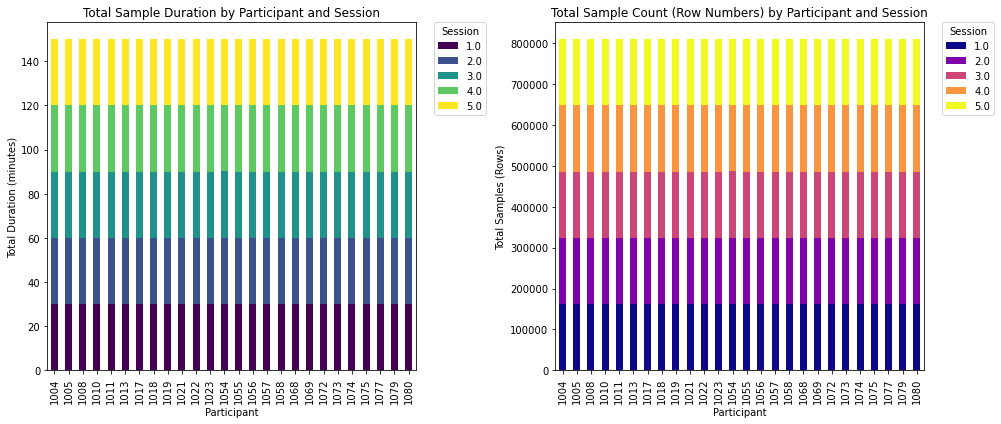

In [297]:
# Total Duration by Participant and Session
duration_summary = dataLength_step1_overview.groupby(['Participant', 'Session'])['SampleDuration'].sum().unstack(fill_value=0)
duration_summary = duration_summary.fillna(0)  # Make sure there are no NaN values

# Total Sample Count (DataLength) by Participant and Session
sample_summary = dataLength_step1_overview.groupby(['Participant', 'Session'])['DataLength'].sum().unstack(fill_value=0)
sample_summary = sample_summary.fillna(0)  # Make sure there are no NaN values

# Plotting Stacked Bar Plots for Sample Duration
plt.figure(figsize=(14, 6))

# Stacked bar plot for Sample Duration
plt.subplot(1, 2, 1)
duration_summary.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Total Sample Duration by Participant and Session')
plt.xlabel('Participant')
plt.ylabel('Total Duration (minutes)')
plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.gca().set_xticklabels(duration_summary.index.astype(int)) 

# Stacked bar plot for Sample Count
plt.subplot(1, 2, 2)
sample_summary.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='plasma')
plt.title('Total Sample Count (Row Numbers) by Participant and Session')
plt.xlabel('Participant')
plt.ylabel('Total Samples (Rows)')
plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.gca().set_xticklabels(duration_summary.index.astype(int)) 

plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_sessions.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()


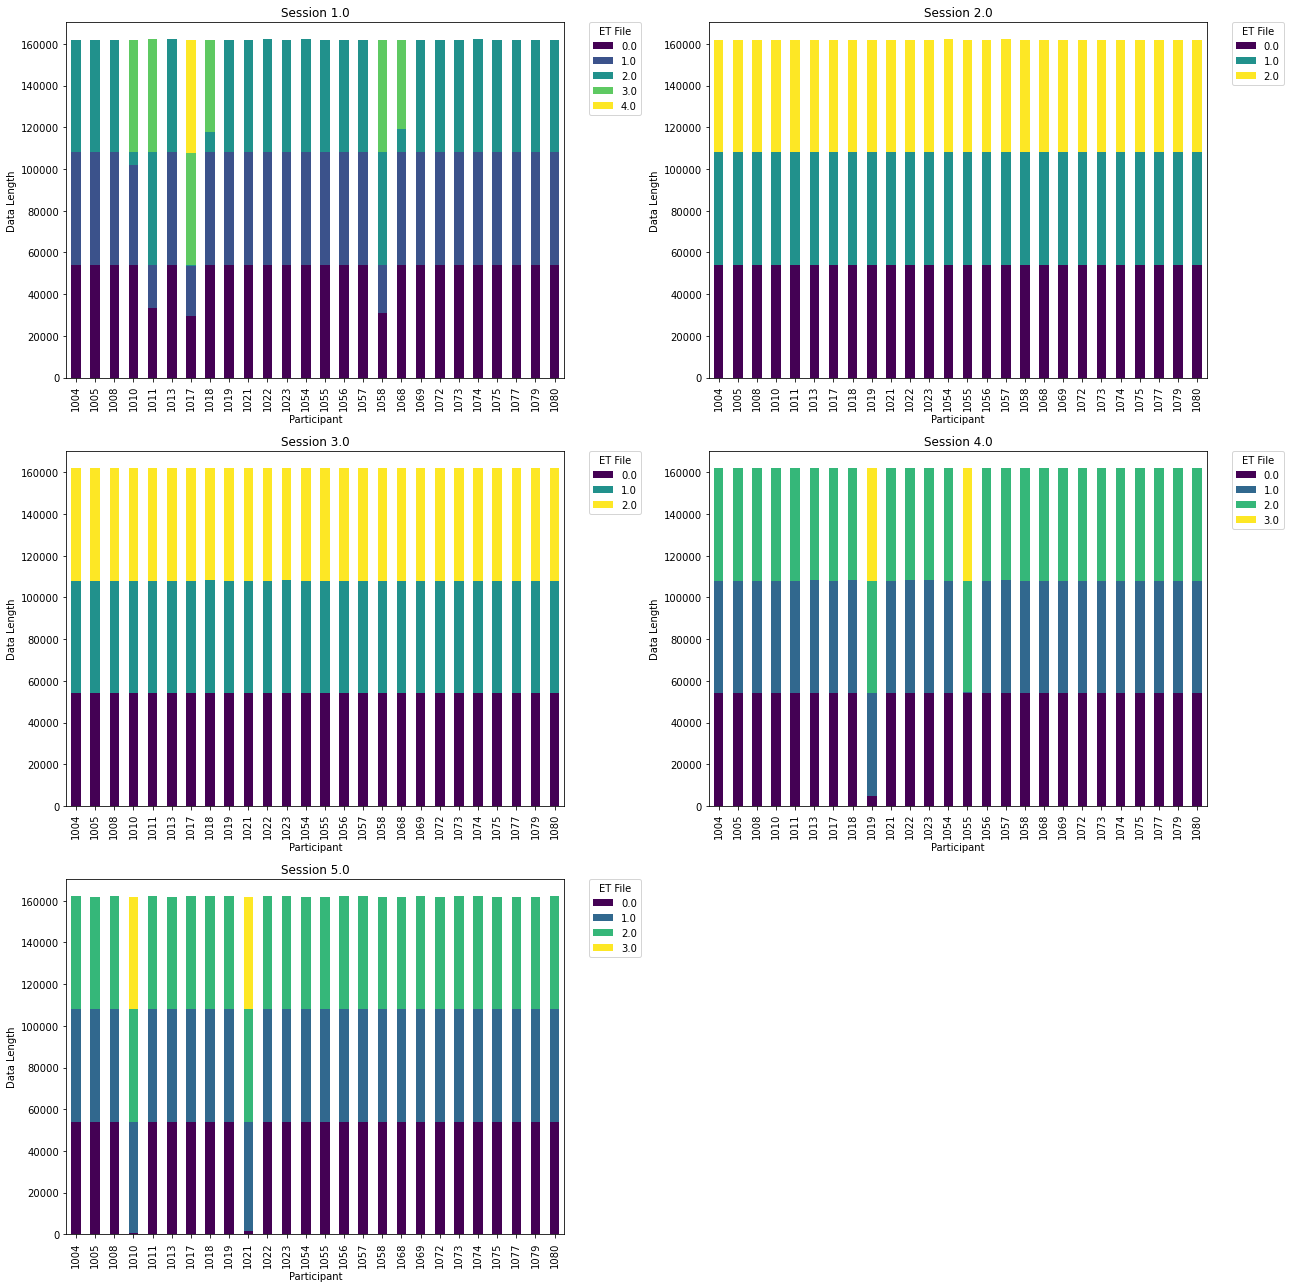

In [298]:
# Assuming you already have the data in your 'dataLength_step1_overview' DataFrame
data = dataLength_step1_overview

# List all unique sessions
unique_sessions = data['Session'].unique()

# Create a 3x2 grid for the plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each session on the grid
plot_counter = 0
for session in unique_sessions:
    # Filter data for the specific session
    session_data = data[data['Session'] == session]

    # Pivot the data to create a DataFrame suitable for stacked bar plotting
    pivot_df = session_data.pivot_table(
        index='Participant',
        columns='ET',
        values='DataLength',
        aggfunc='sum',
        fill_value=0
    )
    
    # Plot the stacked bar plot in the current subplot
    pivot_df.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[plot_counter])

    # Add labels and title
    axes[plot_counter].set_xlabel('Participant')
    axes[plot_counter].set_ylabel('Data Length')
    axes[plot_counter].set_title(f'Session {session}')
    axes[plot_counter].legend(title='ET File', bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    # Set x labels to be integers without decimal
    # Set the x-tick labels using participant IDs
    axes[plot_counter].set_xticks(range(len(pivot_df.index)))
    axes[plot_counter].set_xticklabels(pivot_df.index.astype(int), rotation=90)
    
    plot_counter += 1

# Hide unused subplots (if any)
for i in range(plot_counter, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_5sessions_etfiles.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

plt.show()


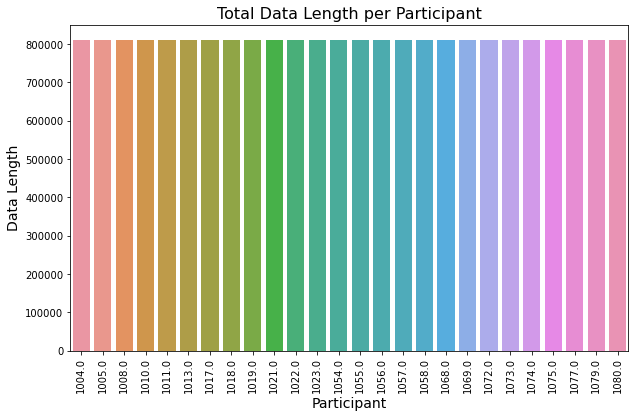

In [299]:
# Summing DataLength for each participant
summed_data = dataLength_step1_overview.groupby('Participant')['DataLength'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each participant showing their summed samples
sns.barplot(x='Participant', y='DataLength', data=summed_data)

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Data Length', fontsize=14)
plt.title('Total Data Length per Participant', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'total_data_length_samples_calc2.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

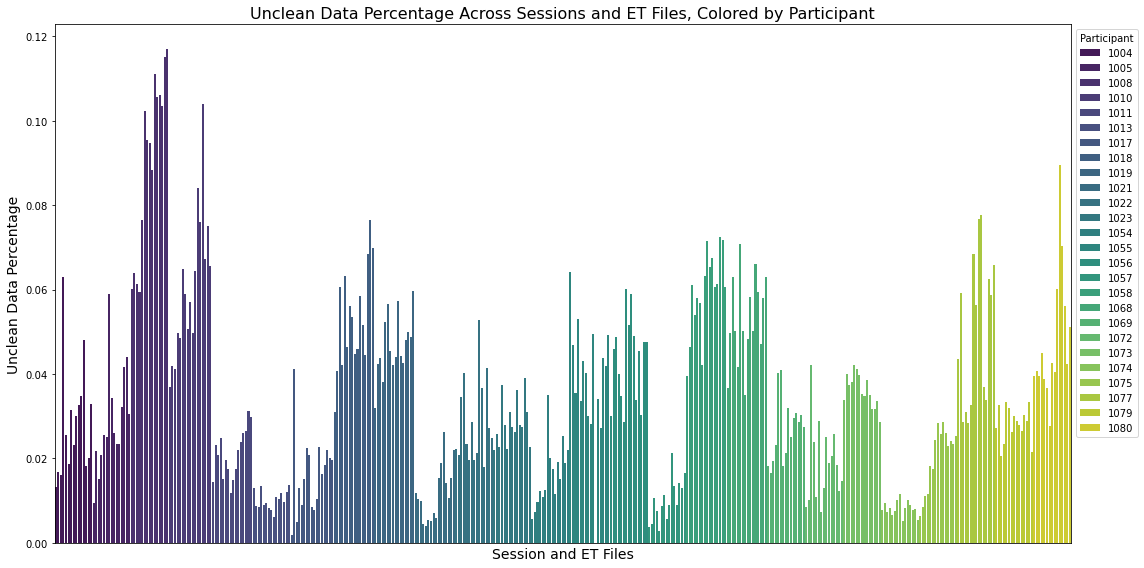

In [322]:
# Concatenate Session and ET for a unique x-axis identifier
dataLength_step1_overview['Session_ET'] = dataLength_step1_overview.apply(lambda row: f"S{row['Session']}_ET{row['ET']}", axis=1)

# Create a unique identifier for plots
dataLength_step1_overview['Session_ET_idx'] = dataLength_step1_overview.index

# Plotting
plt.figure(figsize=(16, 8))
sns.barplot(data=dataLength_step1_overview, x='Session_ET_idx', y='uncleanDataPerc', hue='Participant', dodge=False, palette='viridis')
plt.xticks([])
# Add labels and title
plt.xlabel('Session and ET Files', fontsize=14)
plt.ylabel('Unclean Data Percentage', fontsize=14)
plt.title('Unclean Data Percentage Across Sessions and ET Files, Colored by Participant', fontsize=16)


# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
# Convert labels to integers if needed
labels = [int(float(label)) for label in labels]
plt.legend(handles, labels, title='Participant',   loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'percentage_missingData_allFiles.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

In [320]:
uncleanFiles = dataLength_step1_overview[dataLength_step1_overview['uncleanDataPerc']>0.2]
uncleanFiles.head()

,DataLength,ET,Participant,SampleDuration,Session,UncleanDataCount,uncleanDataPerc,Session_ET,Session_ET_idx


# gaze and saccade stats and plots

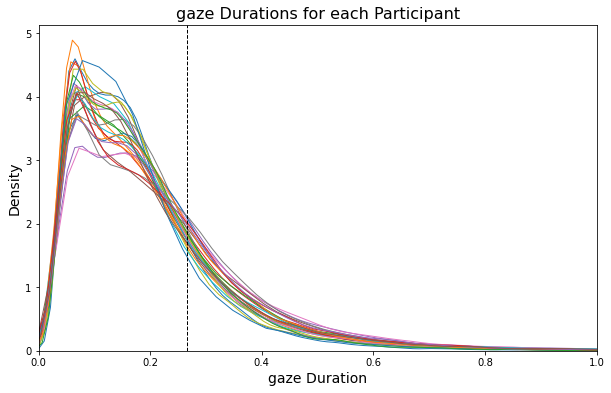

In [300]:
# Approach 1: Plot each participant's gaze durations individually with only the KDE visible
plt.figure(figsize=(10, 6))

for participant in gaze_lengths.columns:
    sns.kdeplot(gaze_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('gaze Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('gaze Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'gaze_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

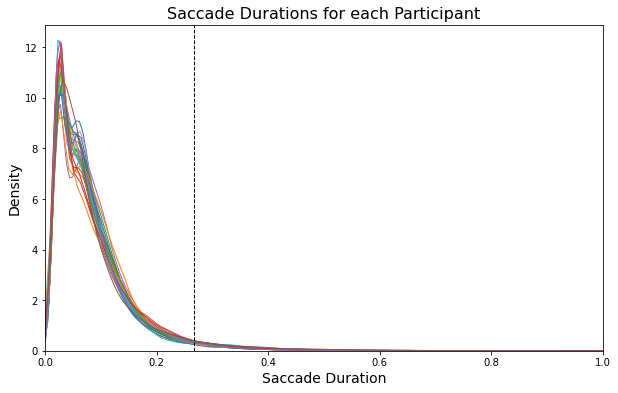

In [301]:
plt.figure(figsize=(10, 6))

for participant in saccade_lengths.columns:
    sns.kdeplot(saccade_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Saccade Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Saccade Durations for each Participant', fontsize=16)

# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'saccade_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

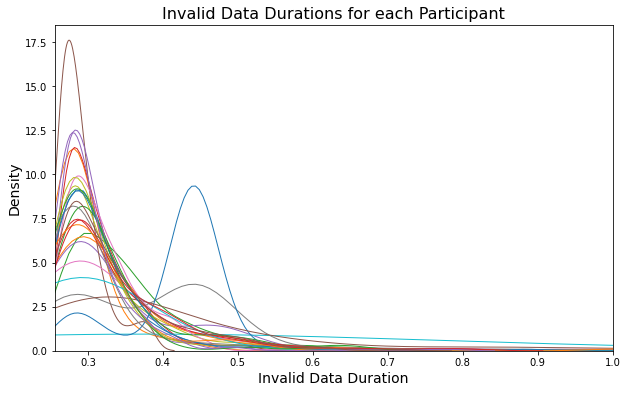

In [302]:
# Check no data distributions
plt.figure(figsize=(10, 6))

# Initialize the minimum value variable
global_min_value = float('inf')

for participant in noData_lengths.columns:
    # Drop NaN values for the participant's data
    participant_data = noData_lengths[participant].dropna()
    
    # Plot the KDE for the participant
    sns.kdeplot(participant_data, label=f'Participant {participant}', linewidth=1)
    
    # Update the global minimum value
    min_value = participant_data.min()
    if min_value < global_min_value:
        global_min_value = min_value

# Add a vertical line for the 0.25 threshold
plt.axvline(x=0.25, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis based on the minimum value and the specified range
plt.xlim(max(0.25, global_min_value), 1)

# Add labels and title
plt.xlabel('Invalid Data Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Invalid Data Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

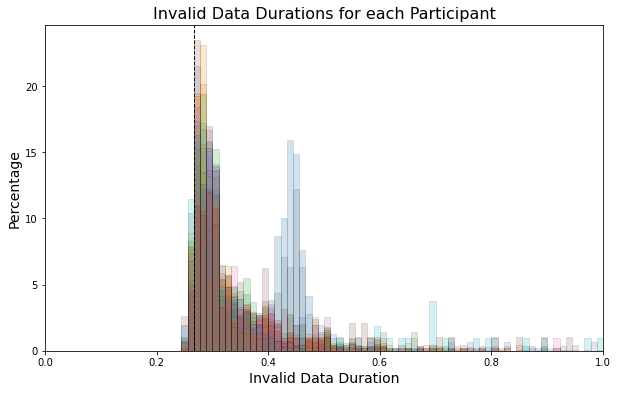

In [303]:
# Define uniform bin width based on the sampling rate of 1/90
bin_width = 1/90

# Check no data distributions
plt.figure(figsize=(10, 6))

# Plot histogram for each participant with low alpha
for participant in noData_lengths.columns:
    participant_data = noData_lengths[participant].dropna()
    plt.hist(participant_data, bins=np.arange(0, 1 + bin_width, bin_width), alpha=0.2, edgecolor='black', linewidth=0.5, density = True)

# Add a vertical line for the 0.25 threshold
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Invalid Data Duration', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Invalid Data Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants_hist.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [304]:
# Combine gaze durations across all participants
combined_gaze_data = pd.concat([gaze_lengths[col].dropna() for col in gaze_lengths.columns])

# Combine saccade durations across all participants
combined_saccade_data = pd.concat([saccade_lengths[col].dropna() for col in saccade_lengths.columns])

combined_noData_data = pd.concat([noData_lengths[col].dropna() for col in noData_lengths.columns])

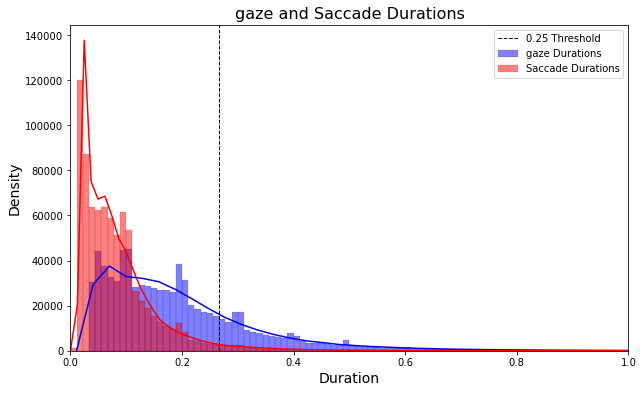

In [305]:
binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for gaze durations in blue
sns.histplot(combined_gaze_data, kde=True, color='blue', label='gaze Durations', binwidth=binwidth )

# Plot KDE for saccade durations in red
sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('gaze and Saccade Durations', fontsize=16)

plt.xlim(0, 1)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'gaze_saccade_durations_allData.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


161731.4999999984
68591.8222222176
3757.044444444498


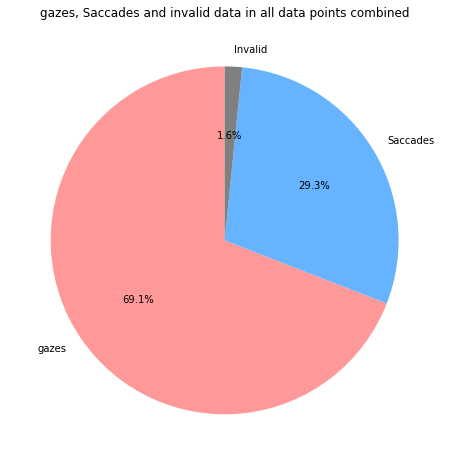

In [306]:
# Combine gaze durations across all participants
combined_gaze_data = pd.concat([gaze_lengths[col].dropna() for col in gaze_lengths.columns])

# Combine saccade durations across all participants
combined_saccade_data = pd.concat([saccade_lengths[col].dropna() for col in saccade_lengths.columns])

combined_noData_data = pd.concat([noData_lengths[col].dropna() for col in noData_lengths.columns])

# Calculate the lengths
# gaze_sum = combined_gaze_data.sum()
# saccade_sum = combined_saccade_data.sum()
# noData_sum = combined_noData_data.sum()

gaze_sum = gaze_lengths.sum().sum()
saccade_sum = saccade_lengths.sum().sum()
noData_sum = noData_lengths.sum().sum()

allD = gaze_sum + saccade_sum + noData_sum
print(gaze_sum)
print(saccade_sum)
print(noData_sum)


# Combine lengths into a list
lengths = [gaze_sum, saccade_sum, noData_sum]

# Define labels for the pie chart
labels = ['gazes', 'Saccades', 'Invalid']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('gazes, Saccades and invalid data in all data points combined')


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

6220.442307692246
2638.147008546831
144.50170940171145


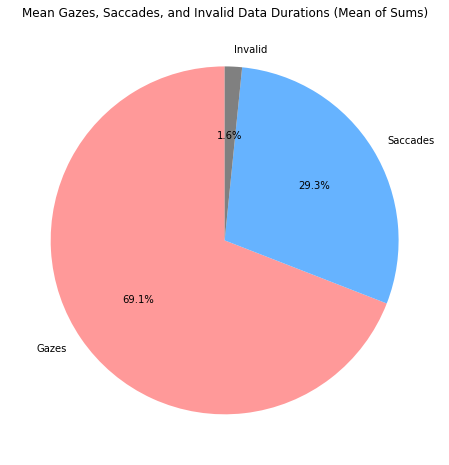

In [307]:
# Calculate the sum durations for each participant

# Calculate the means of the sums
gaze_mean_of_sums =  gaze_lengths.sum().mean()
saccade_mean_of_sums = saccade_lengths.sum().mean()
noData_mean_of_sums = noData_lengths.sum().mean()

allD = gaze_mean_of_sums + saccade_mean_of_sums + noData_mean_of_sums
print(gaze_mean_of_sums)
print(saccade_mean_of_sums)
print(noData_mean_of_sums)

# Combine mean sums into a list
mean_sums = [gaze_mean_of_sums, saccade_mean_of_sums, noData_mean_of_sums]

# Define labels for the pie chart
labels = ['Gazes', 'Saccades', 'Invalid']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(mean_sums, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('Mean Gazes, Saccades, and Invalid Data Durations (Mean of Sums)')


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_mean.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


# Show the figure
plt.show()


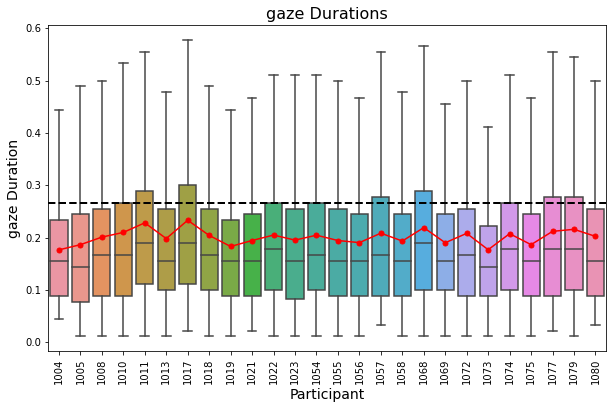

In [308]:
# Assuming you have dataframes: gaze_lengths

# Define the save path and file name separately

# Prepare data for boxplot
gaze_long_format = gaze_lengths.melt(var_name='Participant', value_name='gaze_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='gaze_Duration', data=gaze_long_format, showfliers=False)

# Calculate and plot means
means = gaze_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.2666, color='black', linestyle='--', linewidth=2, label='266.6 ms Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('gaze Duration', fontsize=14)
plt.title('gaze Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'gaze_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


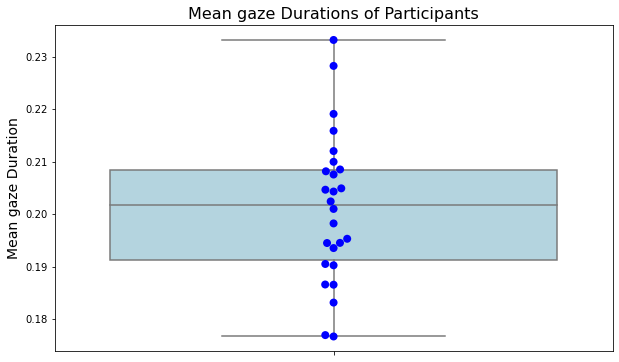

In [309]:

# Calculate the mean gaze duration for each participant
means = gaze_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_gaze_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_gaze_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_gaze_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean gaze Duration', fontsize=14)
plt.title('Mean gaze Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_gaze_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [156]:
allIndexes = checkSmallGazeIndex.values.flatten().tolist()

unique_values = pd.unique(checkSmallGazeIndex.stack())

print(len(unique_values))
print(unique_values)

# Count the number of non-NaN values in each column
non_nan_counts_per_column = checkSmallGazeIndex.count()
print("\nNumber of non-NaN values per column:")
print(non_nan_counts_per_column)

# Count the total number of non-NaN values in the entire DataFrame
total_non_nan_count = non_nan_counts_per_column.sum()
print("\nTotal number of non-NaN values in the DataFrame:")
print(total_non_nan_count)

    
checkSmallGazeIndex.head()

3
[0.01111111 0.02222222 0.03333333]

Number of non-NaN values per column:
1004    0
1005    2
1008    2
1010    2
1011    2
1013    2
1017    2
1018    2
1019    2
1021    2
1022    2
1023    2
1054    2
1055    2
1056    2
1057    2
1058    2
1068    2
1069    2
1072    2
1073    2
1074    2
1075    2
1077    2
1079    2
1080    1
dtype: int64

Total number of non-NaN values in the DataFrame:
49


,1004,1005,1008,1010,1011,1013,1017,1018,1019,1021,...,1058,1068,1069,1072,1073,1074,1075,1077,1079,1080
0,NaN,0.011111,0.011111,0.022222,0.033333,0.011111,0.022222,0.011111,0.022222,0.022222,...,0.011111,0.011111,0.022222,0.033333,0.022222,0.011111,0.033333,0.022222,0.033333,0.033333
1,NaN,0.033333,0.022222,0.011111,0.022222,0.033333,0.022222,0.033333,0.011111,0.033333,...,0.011111,0.011111,0.033333,0.011111,0.011111,0.033333,0.033333,0.033333,0.033333,NaN


In [154]:

gaze_lengths.head()



# Filter for values smaller than 0.04 and unstack to Series
smallDurations = gaze_lengths[gaze_lengths < 0.04].stack()

# Convert to list
smallDurationsList = smallDurations.tolist()

# Print the filtered values as a list
print("\nFiltered values smaller than 0.04:")
print(smallDurationsList)

print(len(smallDurationsList))
    
    


Filtered values smaller than 0.04:
[0.0111111111111111, 0.0222222222222222, 0.0111111111111111, 0.0111111111111111, 0.0111111111111111, 0.0222222222222222, 0.0222222222222222, 0.0111111111111111, 0.0333333333333333, 0.0333333333333333, 0.0111111111111111, 0.0333333333333333, 0.0333333333333333, 0.0333333333333333, 0.0222222222222222, 0.0111111111111111, 0.0111111111111111, 0.0333333333333333, 0.0333333333333333, 0.0222222222222222, 0.0333333333333333, 0.0333333333333333, 0.0222222222222222, 0.0333333333333333, 0.0111111111111111, 0.0222222222222222, 0.0222222222222222, 0.0111111111111111, 0.0111111111111111, 0.0222222222222222, 0.0111111111111111, 0.0222222222222222, 0.0222222222222222, 0.0222222222222222, 0.0222222222222222, 0.0333333333333333, 0.0333333333333333, 0.0111111111111111, 0.0111111111111111, 0.0111111111111111, 0.0111111111111111, 0.0222222222222222, 0.0111111111111111, 0.0111111111111111, 0.0222222222222222, 0.0333333333333333, 0.0111111111111111, 0.0222222222222222, 0.0

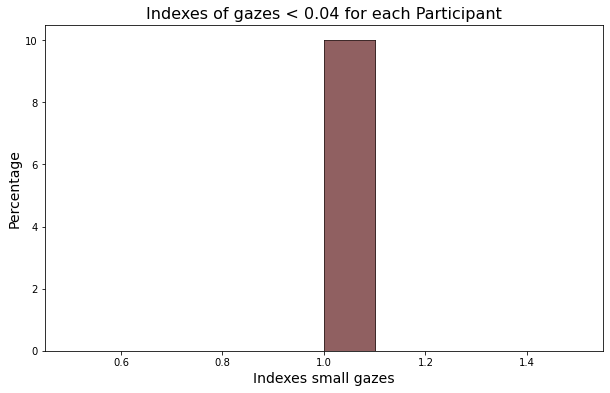

In [143]:
# Define uniform bin width based on the sampling rate of 1/90

# Check no data distributions
plt.figure(figsize=(10, 6))

# Plot histogram for each participant with low alpha
for participant in checkSmallGazeIndex:
    participant_data =  checkSmallGazeIndex[participant].dropna()
    plt.hist(participant_data, alpha=0.4, edgecolor='black', linewidth=0.5, density = True)



# Add labels and title
plt.xlabel('Indexes small gazes', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Indexes of gazes < 0.04 for each Participant', fontsize=16)


# Combine the save path and filename
# full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants_hist.png')

# # Save the figure
# plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


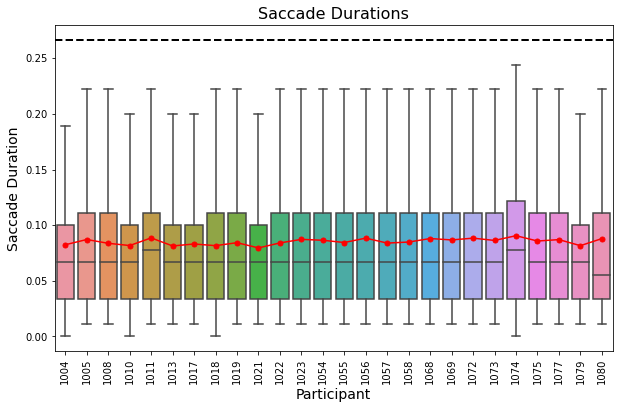

In [310]:
# Assuming you have dataframes: gaze_lengths

# Define the save path and file name separately

# Prepare data for boxplot
saccade_long_format = saccade_lengths.melt(var_name='Participant', value_name='Saccade_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Saccade_Duration', data=saccade_long_format, showfliers=False)

# Calculate and plot means
means = saccade_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.2666, color='black', linestyle='--', linewidth=2, label='266.6ms Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Saccade Duration', fontsize=14)
plt.title('Saccade Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'saccade_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


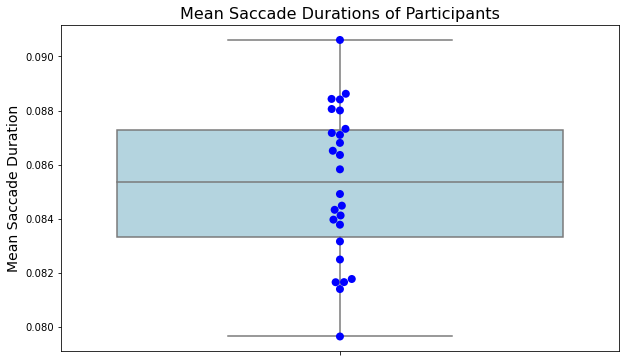

In [311]:

# Calculate the mean gaze duration for each participant
means = saccade_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_Saccade_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_Saccade_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_Saccade_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean Saccade Duration', fontsize=14)
plt.title('Mean Saccade Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_saccade_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


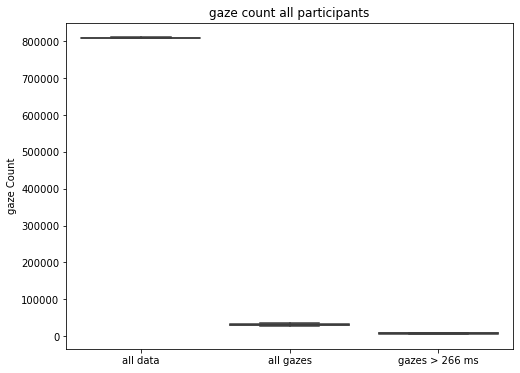

In [329]:


# Count non-NaN values in each column
non_nan_counts = gaze_lengths.notna().sum()

non_nan_dataL = dataLength_overview.notna().sum()


# Count non-NaN values greater than 250 in each column
greater_than_250_counts = gaze_lengths[gaze_lengths > 0.2666].notna().sum()

noBuilding_allFix = gaze_lengths[gaze_lengths > 0.2666].notna().sum()



# Prepare the data for boxplot
counts_df = pd.DataFrame({
    'all data': dataLength_overview.sum(),
    'all gazes': non_nan_counts,
    'gazes > 266 ms': greater_than_250_counts
})





# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=counts_df)
plt.title('gaze count all participants')
plt.ylabel('gaze Count')




# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_gazes_durations_invalidData_sum.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')



plt.show()

In [328]:
dataLength_overview.sum()

1004    810319.0
1005    810121.0
1008    810368.0
1010    810114.0
1011    810542.0
1013    810528.0
1017    810259.0
1018    810551.0
1019    810102.0
1021    810161.0
1022    810485.0
1023    810625.0
1054    810597.0
1055    810196.0
1056    810330.0
1057    810765.0
1058    810305.0
1068    810122.0
1069    810342.0
1072    810015.0
1073    810354.0
1074    810474.0
1075    810108.0
1077    810014.0
1079    810079.0
1080    810157.0
dtype: float64

# intervals

In [313]:
intervals = pd.DataFrame()




# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    gaze_durations = []
    saccade_durations = []
    noD_durations = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intervals) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_interval_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for fileIndex, file in enumerate(file_pbar):

            print('process file ', file)

            # read in data
            int_data = pd.read_csv(os.path.join(data_savepath_intervals, file))
            
            
              # Add participant index, session index, and file index to the data
            int_data['Participant'] = currentPart
            int_data['Session'] = indexSess
            int_data['FileIndex'] = fileIndex

            # Append the interval data to the long-form DataFrame
            intervals = pd.concat([intervals, int_data], ignore_index=True)

# Save the final intervals DataFrame
intervals.to_csv(os.path.join(data_savepath_intervals, 'aggregated_intervals.csv'), index=False)
            




            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             gaze_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     gaze_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and gaze_start_time is not None:
#                     gaze_durations.append((row['timeStampDataPointStart_converted'] - gaze_start_time))
#                     gaze_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None

📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_interval_mad_wobig.csv
process file  1004_Session_1_ET_2_interval_mad_wobig.csv
process file  1004_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_interval_mad_wobig.csv
process file  1004_Session_2_ET_2_interval_mad_wobig.csv
process file  1004_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_interval_mad_wobig.csv
process file  1004_Session_3_ET_2_interval_mad_wobig.csv
process file  1004_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_interval_mad_wobig.csv
process file  1004_Session_4_ET_2_interval_mad_wobig.csv
process file  1004_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_interval_mad_wobig.csv
process file  1004_Session_5_ET_2_interval_mad_wobig.csv
process file  1004_Session_5_ET_3_interval_mad_wobig.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_interval_mad_wobig.csv
process file  1005_Session_1_ET_2_interval_mad_wobig.csv
process file  1005_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_interval_mad_wobig.csv
process file  1005_Session_2_ET_2_interval_mad_wobig.csv
process file  1005_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_interval_mad_wobig.csv
process file  1005_Session_3_ET_2_interval_mad_wobig.csv
process file  1005_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_interval_mad_wobig.csv
process file  1005_Session_4_ET_2_interval_mad_wobig.csv
process file  1005_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_interval_mad_wobig.csv
process file  1005_Session_5_ET_2_interval_mad_wobig.csv
process file  1005_Session_5_ET_3_interval_mad_wobig.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_interval_mad_wobig.csv
process file  1008_Session_1_ET_2_interval_mad_wobig.csv
process file  1008_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_interval_mad_wobig.csv
process file  1008_Session_2_ET_2_interval_mad_wobig.csv
process file  1008_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_interval_mad_wobig.csv
process file  1008_Session_3_ET_2_interval_mad_wobig.csv
process file  1008_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_interval_mad_wobig.csv
process file  1008_Session_4_ET_2_interval_mad_wobig.csv
process file  1008_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_interval_mad_wobig.csv
process file  1008_Session_5_ET_2_interval_mad_wobig.csv
process file  1008_Session_5_ET_3_interval_mad_wobig.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_interval_mad_wobig.csv
process file  1010_Session_1_ET_2_interval_mad_wobig.csv
process file  1010_Session_1_ET_3_interval_mad_wobig.csv
process file  1010_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_interval_mad_wobig.csv
process file  1010_Session_2_ET_2_interval_mad_wobig.csv
process file  1010_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_interval_mad_wobig.csv
process file  1010_Session_3_ET_2_interval_mad_wobig.csv
process file  1010_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_interval_mad_wobig.csv
process file  1010_Session_4_ET_2_interval_mad_wobig.csv
process file  1010_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_interval_mad_wobig.csv
process file  1010_Session_5_ET_2_interval_mad_wobig.csv
process file  1010_Session_5_ET_3_interval_mad_wobig.csv
process file  1010_Session_5_ET_4_interval_mad_wobig.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_interval_mad_wobig.csv
process file  1011_Session_1_ET_2_interval_mad_wobig.csv
process file  1011_Session_1_ET_3_interval_mad_wobig.csv
process file  1011_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_interval_mad_wobig.csv
process file  1011_Session_2_ET_2_interval_mad_wobig.csv
process file  1011_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_interval_mad_wobig.csv
process file  1011_Session_3_ET_2_interval_mad_wobig.csv
process file  1011_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_interval_mad_wobig.csv
process file  1011_Session_4_ET_2_interval_mad_wobig.csv
process file  1011_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_interval_mad_wobig.csv
process file  1011_Session_5_ET_2_interval_mad_wobig.csv
process file  1011_Session_5_ET_3_interval_mad_wobig.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_interval_mad_wobig.csv
process file  1013_Session_1_ET_2_interval_mad_wobig.csv
process file  1013_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_interval_mad_wobig.csv
process file  1013_Session_2_ET_2_interval_mad_wobig.csv
process file  1013_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_interval_mad_wobig.csv
process file  1013_Session_3_ET_2_interval_mad_wobig.csv
process file  1013_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_interval_mad_wobig.csv
process file  1013_Session_4_ET_2_interval_mad_wobig.csv
process file  1013_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_interval_mad_wobig.csv
process file  1013_Session_5_ET_2_interval_mad_wobig.csv
process file  1013_Session_5_ET_3_interval_mad_wobig.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_interval_mad_wobig.csv
process file  1017_Session_1_ET_2_interval_mad_wobig.csv
process file  1017_Session_1_ET_3_interval_mad_wobig.csv
process file  1017_Session_1_ET_4_interval_mad_wobig.csv
process file  1017_Session_1_ET_5_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_interval_mad_wobig.csv
process file  1017_Session_2_ET_2_interval_mad_wobig.csv
process file  1017_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_interval_mad_wobig.csv
process file  1017_Session_3_ET_2_interval_mad_wobig.csv
process file  1017_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_interval_mad_wobig.csv
process file  1017_Session_4_ET_2_interval_mad_wobig.csv
process file  1017_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_interval_mad_wobig.csv
process file  1017_Session_5_ET_2_interval_mad_wobig.csv
process file  1017_Session_5_ET_3_interval_mad_wobig.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_interval_mad_wobig.csv
process file  1018_Session_1_ET_2_interval_mad_wobig.csv
process file  1018_Session_1_ET_3_interval_mad_wobig.csv
process file  1018_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_interval_mad_wobig.csv
process file  1018_Session_2_ET_2_interval_mad_wobig.csv
process file  1018_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_interval_mad_wobig.csv
process file  1018_Session_3_ET_2_interval_mad_wobig.csv
process file  1018_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_interval_mad_wobig.csv
process file  1018_Session_4_ET_2_interval_mad_wobig.csv
process file  1018_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_interval_mad_wobig.csv
process file  1018_Session_5_ET_2_interval_mad_wobig.csv
process file  1018_Session_5_ET_3_interval_mad_wobig.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_interval_mad_wobig.csv
process file  1019_Session_1_ET_2_interval_mad_wobig.csv
process file  1019_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_interval_mad_wobig.csv
process file  1019_Session_2_ET_2_interval_mad_wobig.csv
process file  1019_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_interval_mad_wobig.csv
process file  1019_Session_3_ET_2_interval_mad_wobig.csv
process file  1019_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_interval_mad_wobig.csv
process file  1019_Session_4_ET_2_interval_mad_wobig.csv
process file  1019_Session_4_ET_3_interval_mad_wobig.csv
process file  1019_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_interval_mad_wobig.csv
process file  1019_Session_5_ET_2_interval_mad_wobig.csv
process file  1019_Session_5_ET_3_interval_mad_wobig.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_interval_mad_wobig.csv
process file  1021_Session_1_ET_2_interval_mad_wobig.csv
process file  1021_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_interval_mad_wobig.csv
process file  1021_Session_2_ET_2_interval_mad_wobig.csv
process file  1021_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_interval_mad_wobig.csv
process file  1021_Session_3_ET_2_interval_mad_wobig.csv
process file  1021_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_interval_mad_wobig.csv
process file  1021_Session_4_ET_2_interval_mad_wobig.csv
process file  1021_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_interval_mad_wobig.csv
process file  1021_Session_5_ET_2_interval_mad_wobig.csv
process file  1021_Session_5_ET_3_interval_mad_wobig.csv
process file  1021_Session_5_ET_4_interval_mad_wobig.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_interval_mad_wobig.csv
process file  1022_Session_1_ET_2_interval_mad_wobig.csv
process file  1022_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_interval_mad_wobig.csv
process file  1022_Session_2_ET_2_interval_mad_wobig.csv
process file  1022_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_interval_mad_wobig.csv
process file  1022_Session_3_ET_2_interval_mad_wobig.csv
process file  1022_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_interval_mad_wobig.csv
process file  1022_Session_4_ET_2_interval_mad_wobig.csv
process file  1022_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_interval_mad_wobig.csv
process file  1022_Session_5_ET_2_interval_mad_wobig.csv
process file  1022_Session_5_ET_3_interval_mad_wobig.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_interval_mad_wobig.csv
process file  1023_Session_1_ET_2_interval_mad_wobig.csv
process file  1023_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_interval_mad_wobig.csv
process file  1023_Session_2_ET_2_interval_mad_wobig.csv
process file  1023_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_interval_mad_wobig.csv
process file  1023_Session_3_ET_2_interval_mad_wobig.csv
process file  1023_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_interval_mad_wobig.csv
process file  1023_Session_4_ET_2_interval_mad_wobig.csv
process file  1023_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_interval_mad_wobig.csv
process file  1023_Session_5_ET_2_interval_mad_wobig.csv
process file  1023_Session_5_ET_3_interval_mad_wobig.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_interval_mad_wobig.csv
process file  1054_Session_1_ET_2_interval_mad_wobig.csv
process file  1054_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_interval_mad_wobig.csv
process file  1054_Session_2_ET_2_interval_mad_wobig.csv
process file  1054_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_interval_mad_wobig.csv
process file  1054_Session_3_ET_2_interval_mad_wobig.csv
process file  1054_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_interval_mad_wobig.csv
process file  1054_Session_4_ET_2_interval_mad_wobig.csv
process file  1054_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_interval_mad_wobig.csv
process file  1054_Session_5_ET_2_interval_mad_wobig.csv
process file  1054_Session_5_ET_3_interval_mad_wobig.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_interval_mad_wobig.csv
process file  1055_Session_1_ET_2_interval_mad_wobig.csv
process file  1055_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_interval_mad_wobig.csv
process file  1055_Session_2_ET_2_interval_mad_wobig.csv
process file  1055_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_interval_mad_wobig.csv
process file  1055_Session_3_ET_2_interval_mad_wobig.csv
process file  1055_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_interval_mad_wobig.csv
process file  1055_Session_4_ET_2_interval_mad_wobig.csv
process file  1055_Session_4_ET_3_interval_mad_wobig.csv
process file  1055_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_interval_mad_wobig.csv
process file  1055_Session_5_ET_2_interval_mad_wobig.csv
process file  1055_Session_5_ET_3_interval_mad_wobig.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_interval_mad_wobig.csv
process file  1056_Session_1_ET_2_interval_mad_wobig.csv
process file  1056_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_interval_mad_wobig.csv
process file  1056_Session_2_ET_2_interval_mad_wobig.csv
process file  1056_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_interval_mad_wobig.csv
process file  1056_Session_3_ET_2_interval_mad_wobig.csv
process file  1056_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_interval_mad_wobig.csv
process file  1056_Session_4_ET_2_interval_mad_wobig.csv
process file  1056_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_interval_mad_wobig.csv
process file  1056_Session_5_ET_2_interval_mad_wobig.csv
process file  1056_Session_5_ET_3_interval_mad_wobig.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_interval_mad_wobig.csv
process file  1057_Session_1_ET_2_interval_mad_wobig.csv
process file  1057_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_interval_mad_wobig.csv
process file  1057_Session_2_ET_2_interval_mad_wobig.csv
process file  1057_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_interval_mad_wobig.csv
process file  1057_Session_3_ET_2_interval_mad_wobig.csv
process file  1057_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_interval_mad_wobig.csv
process file  1057_Session_4_ET_2_interval_mad_wobig.csv
process file  1057_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_interval_mad_wobig.csv
process file  1057_Session_5_ET_2_interval_mad_wobig.csv
process file  1057_Session_5_ET_3_interval_mad_wobig.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_interval_mad_wobig.csv
process file  1058_Session_1_ET_2_interval_mad_wobig.csv
process file  1058_Session_1_ET_3_interval_mad_wobig.csv
process file  1058_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_interval_mad_wobig.csv
process file  1058_Session_2_ET_2_interval_mad_wobig.csv
process file  1058_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_interval_mad_wobig.csv
process file  1058_Session_3_ET_2_interval_mad_wobig.csv
process file  1058_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_interval_mad_wobig.csv
process file  1058_Session_4_ET_2_interval_mad_wobig.csv
process file  1058_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_interval_mad_wobig.csv
process file  1058_Session_5_ET_2_interval_mad_wobig.csv
process file  1058_Session_5_ET_3_interval_mad_wobig.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_interval_mad_wobig.csv
process file  1068_Session_1_ET_2_interval_mad_wobig.csv
process file  1068_Session_1_ET_3_interval_mad_wobig.csv
process file  1068_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_interval_mad_wobig.csv
process file  1068_Session_2_ET_2_interval_mad_wobig.csv
process file  1068_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_interval_mad_wobig.csv
process file  1068_Session_3_ET_2_interval_mad_wobig.csv
process file  1068_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_interval_mad_wobig.csv
process file  1068_Session_4_ET_2_interval_mad_wobig.csv
process file  1068_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_interval_mad_wobig.csv
process file  1068_Session_5_ET_2_interval_mad_wobig.csv
process file  1068_Session_5_ET_3_interval_mad_wobig.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_interval_mad_wobig.csv
process file  1069_Session_1_ET_2_interval_mad_wobig.csv
process file  1069_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_interval_mad_wobig.csv
process file  1069_Session_2_ET_2_interval_mad_wobig.csv
process file  1069_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_interval_mad_wobig.csv
process file  1069_Session_3_ET_2_interval_mad_wobig.csv
process file  1069_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_interval_mad_wobig.csv
process file  1069_Session_4_ET_2_interval_mad_wobig.csv
process file  1069_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_interval_mad_wobig.csv
process file  1069_Session_5_ET_2_interval_mad_wobig.csv
process file  1069_Session_5_ET_3_interval_mad_wobig.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_interval_mad_wobig.csv
process file  1072_Session_1_ET_2_interval_mad_wobig.csv
process file  1072_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_interval_mad_wobig.csv
process file  1072_Session_2_ET_2_interval_mad_wobig.csv
process file  1072_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_interval_mad_wobig.csv
process file  1072_Session_3_ET_2_interval_mad_wobig.csv
process file  1072_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_interval_mad_wobig.csv
process file  1072_Session_4_ET_2_interval_mad_wobig.csv
process file  1072_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_interval_mad_wobig.csv
process file  1072_Session_5_ET_2_interval_mad_wobig.csv
process file  1072_Session_5_ET_3_interval_mad_wobig.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_interval_mad_wobig.csv
process file  1073_Session_1_ET_2_interval_mad_wobig.csv
process file  1073_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_interval_mad_wobig.csv
process file  1073_Session_2_ET_2_interval_mad_wobig.csv
process file  1073_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_interval_mad_wobig.csv
process file  1073_Session_3_ET_2_interval_mad_wobig.csv
process file  1073_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_interval_mad_wobig.csv
process file  1073_Session_4_ET_2_interval_mad_wobig.csv
process file  1073_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_interval_mad_wobig.csv
process file  1073_Session_5_ET_2_interval_mad_wobig.csv
process file  1073_Session_5_ET_3_interval_mad_wobig.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_interval_mad_wobig.csv
process file  1074_Session_1_ET_2_interval_mad_wobig.csv
process file  1074_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_interval_mad_wobig.csv
process file  1074_Session_2_ET_2_interval_mad_wobig.csv
process file  1074_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_interval_mad_wobig.csv
process file  1074_Session_3_ET_2_interval_mad_wobig.csv
process file  1074_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_interval_mad_wobig.csv
process file  1074_Session_4_ET_2_interval_mad_wobig.csv
process file  1074_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_interval_mad_wobig.csv
process file  1074_Session_5_ET_2_interval_mad_wobig.csv
process file  1074_Session_5_ET_3_interval_mad_wobig.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_interval_mad_wobig.csv
process file  1075_Session_1_ET_2_interval_mad_wobig.csv
process file  1075_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_interval_mad_wobig.csv
process file  1075_Session_2_ET_2_interval_mad_wobig.csv
process file  1075_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_interval_mad_wobig.csv
process file  1075_Session_3_ET_2_interval_mad_wobig.csv
process file  1075_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_interval_mad_wobig.csv
process file  1075_Session_4_ET_2_interval_mad_wobig.csv
process file  1075_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_interval_mad_wobig.csv
process file  1075_Session_5_ET_2_interval_mad_wobig.csv
process file  1075_Session_5_ET_3_interval_mad_wobig.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_interval_mad_wobig.csv
process file  1077_Session_1_ET_2_interval_mad_wobig.csv
process file  1077_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_interval_mad_wobig.csv
process file  1077_Session_2_ET_2_interval_mad_wobig.csv
process file  1077_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_interval_mad_wobig.csv
process file  1077_Session_3_ET_2_interval_mad_wobig.csv
process file  1077_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_interval_mad_wobig.csv
process file  1077_Session_4_ET_2_interval_mad_wobig.csv
process file  1077_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_interval_mad_wobig.csv
process file  1077_Session_5_ET_2_interval_mad_wobig.csv
process file  1077_Session_5_ET_3_interval_mad_wobig.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_interval_mad_wobig.csv
process file  1079_Session_1_ET_2_interval_mad_wobig.csv
process file  1079_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_interval_mad_wobig.csv
process file  1079_Session_2_ET_2_interval_mad_wobig.csv
process file  1079_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_interval_mad_wobig.csv
process file  1079_Session_3_ET_2_interval_mad_wobig.csv
process file  1079_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_interval_mad_wobig.csv
process file  1079_Session_4_ET_2_interval_mad_wobig.csv
process file  1079_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_interval_mad_wobig.csv
process file  1079_Session_5_ET_2_interval_mad_wobig.csv
process file  1079_Session_5_ET_3_interval_mad_wobig.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_interval_mad_wobig.csv
process file  1080_Session_1_ET_2_interval_mad_wobig.csv
process file  1080_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_interval_mad_wobig.csv
process file  1080_Session_2_ET_2_interval_mad_wobig.csv
process file  1080_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_interval_mad_wobig.csv
process file  1080_Session_3_ET_2_interval_mad_wobig.csv
process file  1080_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_interval_mad_wobig.csv
process file  1080_Session_4_ET_2_interval_mad_wobig.csv
process file  1080_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_interval_mad_wobig.csv
process file  1080_Session_5_ET_2_interval_mad_wobig.csv
process file  1080_Session_5_ET_3_interval_mad_wobig.csv


In [314]:
intervals.head()

,index,start,end,start_idx,end_idx,total_vels,thresh,Participant,Session,FileIndex
0,0,0.000000,0.133333,0,12,596.657913,25.631436,1004,1,0
1,4,0.177778,0.877778,16,79,2573.402313,26.992140,1004,1,0
2,10,0.933333,1.677778,84,151,1155.323648,33.160137,1004,1,0
3,12,1.700000,1.911111,153,172,823.342669,7.023075,1004,1,0
4,16,1.944444,2.188889,175,197,1018.578097,55.131253,1004,1,0


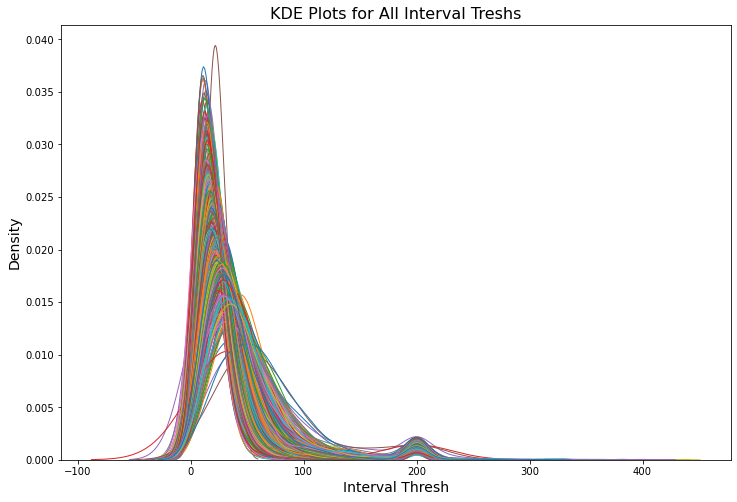

In [315]:

# Assuming the `intervals` DataFrame is already created from previous steps

plt.figure(figsize=(12, 8))

# Loop through each unique combination of Participant, Session, and FileIndex
grouped_intervals = intervals.groupby(['Participant', 'Session', 'FileIndex'])

for (participant, session, file_index), group in grouped_intervals:
    sns.kdeplot(group['thresh'].dropna(), label=f'P{participant}_S{session}_F{file_index}', linewidth=1)
    
# Add labels and title
plt.xlabel('Interval Thresh', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('KDE Plots for All Interval Treshs', fontsize=16)



# Save the figure
savepath = os.path.join(data_savepath_plots, 'all_intervals_thresh_individual.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


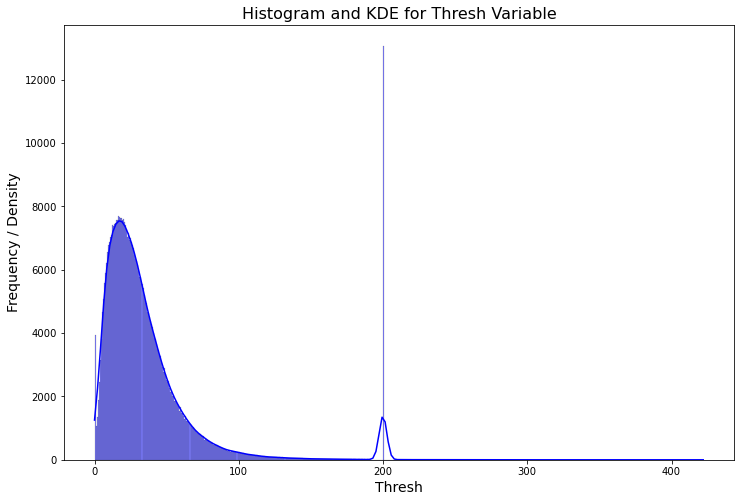

In [316]:
# Extract the 'thresh' values from intervals DataFrame
thresh_values = intervals['thresh'].dropna()

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
sns.histplot(thresh_values, kde=True, color='blue')

# Add labels and title
plt.xlabel('Thresh', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram and KDE for Thresh Variable', fontsize=16)

# Save the figure
savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [317]:
print(np.max(intervals['thresh']))

larger200 = intervals['thresh']> 200
print(sum(larger200))
print(sum(larger200)/len(larger200))

421.99187936380974
397
0.0008474431551354629


# check name variable and original hit point names 

In [49]:
def analyze_gazes(df):
    results = []
    bugCounter = 0
    
    # Find all indices where gazes start and end
    gaze_starts = df[df['events'] == 2.0].index.tolist()
    gaze_ends = df[df['events'] == -2.0].index.tolist()

    if len(gaze_starts) != len(gaze_ends):
        if len(gaze_starts) < len(gaze_ends):
            if gaze_ends[0] == 1:
                del gaze_ends[0]
                bugCounter += 1
                if len(gaze_starts) != len(gaze_ends):
                    print(len(gaze_starts))
                    print(len(gaze_ends))
                    raise ValueError("Mismatch between start and end of gazes, after removing known bug 1.")
            else:
                print(len(gaze_starts))
                print(len(gaze_ends))
                raise ValueError("Mismatch between start and end of gazes - unknown bug 2.")
                
        else:
            print(len(gaze_starts))
            print(len(gaze_ends))
            raise ValueError("Mismatch between start and end of gazes - unknown bug 3.")

    
    
    for start, end in zip(gaze_starts, gaze_ends):
        gaze_data = df.loc[start:end]  # Include the rows with 2.0 and -2.0
        
        # Calculate the total number of rows including NaNs
        total_rows = len(gaze_data)
        
        # Exclude NaN values for counting occurrences
        non_nan_gaze_data = gaze_data.dropna(subset=['processedCollider_NH_name'])
        name_counter = non_nan_gaze_data['processedCollider_NH_name'].value_counts()

        # Convert the value counts to a dictionary for custom max logic
        resNH = name_counter.to_dict()
        
        # Check if any non-string values occur
        has_non_string_values = any(not isinstance(key, str) for key in resNH.keys())
        
        max_name = None
        max_occurrences = 0
        max_percentage = 0
        is_max_NH = None
        
        second_max_name = None
        second_max_occurrences = 0
        second_max_percentage = 0
        is_second_max_NH = None
        
        if resNH:
            # Find max occurring string key
            max_name = max((key for key in resNH.keys() if isinstance(key, str)), key=lambda new_k: resNH[new_k])
            max_occurrences = resNH[max_name]
            max_percentage = max_occurrences / total_rows if total_rows > 0 else 0

            # Check if max element is an NH element (use the row index of the max element)
            is_max_NH = gaze_data.loc[gaze_data['processedCollider_NH_name'] == max_name, 'processedCollider_NH_IsNH'].mode()[0]

            if len(resNH) > 1:
                # Find second max occurring string key
                second_max_name = max(
                    (key for key in resNH.keys() if isinstance(key, str) and key != max_name),
                    key=lambda new_k: resNH[new_k], default=None)
                if second_max_name:
                    second_max_occurrences = resNH[second_max_name]
                    second_max_percentage = second_max_occurrences / total_rows

                    # Check if second max element is an NH element (use the row index of the second max element)
                    is_second_max_NH = gaze_data.loc[gaze_data['processedCollider_NH_name'] == second_max_name, 'processedCollider_NH_IsNH'].mode()[0]
        
        result = {
            'MaxName': max_name,
            'MaxPercentage': max_percentage,
            'IsMaxNH': is_max_NH,
            'SecondMaxName': second_max_name,
            'SecondMaxPercentage': second_max_percentage,
            'IsSecondMaxNH': is_second_max_NH,
            'HasNonStringValues': has_non_string_values
        }
        results.append(result)
    
    return results, bugCounter

In [50]:
print('start')


overview_results = []
bugCounter_all = 0



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    gaze_durations = []
    saccade_durations = []
    noD_durations = []
    fix_NH_durations = []
    dataLength = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file_index, file in enumerate(file_pbar):

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
            
            # Analyze gazes in the current file
            file_results, bugCount = analyze_gazes(data)
            
            bugCounter_all = bugCounter_all + bugCount

            # Append results to overview with additional context
            for result in file_results:
                result['Participant'] = currentPart
                result['Session'] = indexSess
                result['FileIndex'] = file_index
                overview_results.append(result)

# Create an overview DataFrame from the results
overview_df = pd.DataFrame(overview_results)

print('number of files with known bug: ', bugCounter_all)

# # Display or save the overview DataFrame
# print(overview_df.head())
# # Save the overview to a CSV file if needed
# overview_df.to_csv('gaze_analysis_overview.csv', index=False)
           

start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv
process file  1004_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_processed_gazes.csv
process file  1004_Session_2_ET_2_data_processed_gazes.csv
process file  1004_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_processed_gazes.csv
process file  1004_Session_3_ET_2_data_processed_gazes.csv
process file  1004_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_processed_gazes.csv
process file  1004_Session_4_ET_2_data_processed_gazes.csv
process file  1004_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_processed_gazes.csv
process file  1004_Session_5_ET_2_data_processed_gazes.csv
process file  1004_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_processed_gazes.csv
process file  1005_Session_1_ET_2_data_processed_gazes.csv
process file  1005_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_processed_gazes.csv
process file  1005_Session_2_ET_2_data_processed_gazes.csv
process file  1005_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_processed_gazes.csv
process file  1005_Session_3_ET_2_data_processed_gazes.csv
process file  1005_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_processed_gazes.csv
process file  1005_Session_4_ET_2_data_processed_gazes.csv
process file  1005_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_processed_gazes.csv
process file  1005_Session_5_ET_2_data_processed_gazes.csv
process file  1005_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_processed_gazes.csv
process file  1008_Session_1_ET_2_data_processed_gazes.csv
process file  1008_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_processed_gazes.csv
process file  1008_Session_2_ET_2_data_processed_gazes.csv
process file  1008_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_processed_gazes.csv
process file  1008_Session_3_ET_2_data_processed_gazes.csv
process file  1008_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_processed_gazes.csv
process file  1008_Session_4_ET_2_data_processed_gazes.csv
process file  1008_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_processed_gazes.csv
process file  1008_Session_5_ET_2_data_processed_gazes.csv
process file  1008_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_processed_gazes.csv
process file  1010_Session_1_ET_2_data_processed_gazes.csv
process file  1010_Session_1_ET_3_data_processed_gazes.csv
process file  1010_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_processed_gazes.csv
process file  1010_Session_2_ET_2_data_processed_gazes.csv
process file  1010_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_processed_gazes.csv
process file  1010_Session_3_ET_2_data_processed_gazes.csv
process file  1010_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_processed_gazes.csv
process file  1010_Session_4_ET_2_data_processed_gazes.csv
process file  1010_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_processed_gazes.csv
process file  1010_Session_5_ET_2_data_processed_gazes.csv
process file  1010_Session_5_ET_3_data_processed_gazes.csv
process file  1010_Session_5_ET_4_data_processed_gazes.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_processed_gazes.csv
process file  1011_Session_1_ET_2_data_processed_gazes.csv
process file  1011_Session_1_ET_3_data_processed_gazes.csv
process file  1011_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_processed_gazes.csv
process file  1011_Session_2_ET_2_data_processed_gazes.csv
process file  1011_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_processed_gazes.csv
process file  1011_Session_3_ET_2_data_processed_gazes.csv
process file  1011_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_processed_gazes.csv
process file  1011_Session_4_ET_2_data_processed_gazes.csv
process file  1011_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_processed_gazes.csv
process file  1011_Session_5_ET_2_data_processed_gazes.csv
process file  1011_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_processed_gazes.csv
process file  1013_Session_1_ET_2_data_processed_gazes.csv
process file  1013_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_processed_gazes.csv
process file  1013_Session_2_ET_2_data_processed_gazes.csv
process file  1013_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_processed_gazes.csv
process file  1013_Session_3_ET_2_data_processed_gazes.csv
process file  1013_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_processed_gazes.csv
process file  1013_Session_4_ET_2_data_processed_gazes.csv
process file  1013_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_processed_gazes.csv
process file  1013_Session_5_ET_2_data_processed_gazes.csv
process file  1013_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_processed_gazes.csv
process file  1017_Session_1_ET_2_data_processed_gazes.csv
process file  1017_Session_1_ET_3_data_processed_gazes.csv
process file  1017_Session_1_ET_4_data_processed_gazes.csv
process file  1017_Session_1_ET_5_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_processed_gazes.csv
process file  1017_Session_2_ET_2_data_processed_gazes.csv
process file  1017_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_processed_gazes.csv
process file  1017_Session_3_ET_2_data_processed_gazes.csv
process file  1017_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_processed_gazes.csv
process file  1017_Session_4_ET_2_data_processed_gazes.csv
process file  1017_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_processed_gazes.csv
process file  1017_Session_5_ET_2_data_processed_gazes.csv
process file  1017_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_processed_gazes.csv
process file  1018_Session_1_ET_2_data_processed_gazes.csv
process file  1018_Session_1_ET_3_data_processed_gazes.csv
process file  1018_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_processed_gazes.csv
process file  1018_Session_2_ET_2_data_processed_gazes.csv
process file  1018_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_processed_gazes.csv
process file  1018_Session_3_ET_2_data_processed_gazes.csv
process file  1018_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_processed_gazes.csv
process file  1018_Session_4_ET_2_data_processed_gazes.csv
process file  1018_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_processed_gazes.csv
process file  1018_Session_5_ET_2_data_processed_gazes.csv
process file  1018_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_processed_gazes.csv
process file  1019_Session_1_ET_2_data_processed_gazes.csv
process file  1019_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_processed_gazes.csv
process file  1019_Session_2_ET_2_data_processed_gazes.csv
process file  1019_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_processed_gazes.csv
process file  1019_Session_3_ET_2_data_processed_gazes.csv
process file  1019_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_processed_gazes.csv
process file  1019_Session_4_ET_2_data_processed_gazes.csv
process file  1019_Session_4_ET_3_data_processed_gazes.csv
process file  1019_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_processed_gazes.csv
process file  1019_Session_5_ET_2_data_processed_gazes.csv
process file  1019_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_processed_gazes.csv
process file  1021_Session_1_ET_2_data_processed_gazes.csv
process file  1021_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_processed_gazes.csv
process file  1021_Session_2_ET_2_data_processed_gazes.csv
process file  1021_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_processed_gazes.csv
process file  1021_Session_3_ET_2_data_processed_gazes.csv
process file  1021_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_processed_gazes.csv
process file  1021_Session_4_ET_2_data_processed_gazes.csv
process file  1021_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_processed_gazes.csv
process file  1021_Session_5_ET_2_data_processed_gazes.csv
process file  1021_Session_5_ET_3_data_processed_gazes.csv
process file  1021_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_processed_gazes.csv
process file  1022_Session_1_ET_2_data_processed_gazes.csv
process file  1022_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_processed_gazes.csv
process file  1022_Session_2_ET_2_data_processed_gazes.csv
process file  1022_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_processed_gazes.csv
process file  1022_Session_3_ET_2_data_processed_gazes.csv
process file  1022_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_processed_gazes.csv
process file  1022_Session_4_ET_2_data_processed_gazes.csv
process file  1022_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_processed_gazes.csv
process file  1022_Session_5_ET_2_data_processed_gazes.csv
process file  1022_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_processed_gazes.csv
process file  1023_Session_1_ET_2_data_processed_gazes.csv
process file  1023_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_processed_gazes.csv
process file  1023_Session_2_ET_2_data_processed_gazes.csv
process file  1023_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_processed_gazes.csv
process file  1023_Session_3_ET_2_data_processed_gazes.csv
process file  1023_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_processed_gazes.csv
process file  1023_Session_4_ET_2_data_processed_gazes.csv
process file  1023_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_processed_gazes.csv
process file  1023_Session_5_ET_2_data_processed_gazes.csv
process file  1023_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_processed_gazes.csv
process file  1054_Session_1_ET_2_data_processed_gazes.csv
process file  1054_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_processed_gazes.csv
process file  1054_Session_2_ET_2_data_processed_gazes.csv
process file  1054_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_processed_gazes.csv
process file  1054_Session_3_ET_2_data_processed_gazes.csv
process file  1054_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_processed_gazes.csv
process file  1054_Session_4_ET_2_data_processed_gazes.csv
process file  1054_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_processed_gazes.csv
process file  1054_Session_5_ET_2_data_processed_gazes.csv
process file  1054_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_processed_gazes.csv
process file  1055_Session_1_ET_2_data_processed_gazes.csv
process file  1055_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_processed_gazes.csv
process file  1055_Session_2_ET_2_data_processed_gazes.csv
process file  1055_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_processed_gazes.csv
process file  1055_Session_3_ET_2_data_processed_gazes.csv
process file  1055_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_processed_gazes.csv
process file  1055_Session_4_ET_2_data_processed_gazes.csv
process file  1055_Session_4_ET_3_data_processed_gazes.csv
process file  1055_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_processed_gazes.csv
process file  1055_Session_5_ET_2_data_processed_gazes.csv
process file  1055_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_processed_gazes.csv
process file  1056_Session_1_ET_2_data_processed_gazes.csv
process file  1056_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_processed_gazes.csv
process file  1056_Session_2_ET_2_data_processed_gazes.csv
process file  1056_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_processed_gazes.csv
process file  1056_Session_3_ET_2_data_processed_gazes.csv
process file  1056_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_processed_gazes.csv
process file  1056_Session_4_ET_2_data_processed_gazes.csv
process file  1056_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_processed_gazes.csv
process file  1056_Session_5_ET_2_data_processed_gazes.csv
process file  1056_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_processed_gazes.csv
process file  1057_Session_1_ET_2_data_processed_gazes.csv
process file  1057_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_processed_gazes.csv
process file  1057_Session_2_ET_2_data_processed_gazes.csv
process file  1057_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_processed_gazes.csv
process file  1057_Session_3_ET_2_data_processed_gazes.csv
process file  1057_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_processed_gazes.csv
process file  1057_Session_4_ET_2_data_processed_gazes.csv
process file  1057_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_processed_gazes.csv
process file  1057_Session_5_ET_2_data_processed_gazes.csv
process file  1057_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_processed_gazes.csv
process file  1058_Session_1_ET_2_data_processed_gazes.csv
process file  1058_Session_1_ET_3_data_processed_gazes.csv
process file  1058_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_processed_gazes.csv
process file  1058_Session_2_ET_2_data_processed_gazes.csv
process file  1058_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_processed_gazes.csv
process file  1058_Session_3_ET_2_data_processed_gazes.csv
process file  1058_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_processed_gazes.csv
process file  1058_Session_4_ET_2_data_processed_gazes.csv
process file  1058_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_processed_gazes.csv
process file  1058_Session_5_ET_2_data_processed_gazes.csv
process file  1058_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_processed_gazes.csv
process file  1068_Session_1_ET_2_data_processed_gazes.csv
process file  1068_Session_1_ET_3_data_processed_gazes.csv
process file  1068_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_processed_gazes.csv
process file  1068_Session_2_ET_2_data_processed_gazes.csv
process file  1068_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_processed_gazes.csv
process file  1068_Session_3_ET_2_data_processed_gazes.csv
process file  1068_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_processed_gazes.csv
process file  1068_Session_4_ET_2_data_processed_gazes.csv
process file  1068_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_processed_gazes.csv
process file  1068_Session_5_ET_2_data_processed_gazes.csv
process file  1068_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_processed_gazes.csv
process file  1069_Session_1_ET_2_data_processed_gazes.csv
process file  1069_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_processed_gazes.csv
process file  1069_Session_2_ET_2_data_processed_gazes.csv
process file  1069_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_processed_gazes.csv
process file  1069_Session_3_ET_2_data_processed_gazes.csv
process file  1069_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_processed_gazes.csv
process file  1069_Session_4_ET_2_data_processed_gazes.csv
process file  1069_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_processed_gazes.csv
process file  1069_Session_5_ET_2_data_processed_gazes.csv
process file  1069_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_processed_gazes.csv
process file  1072_Session_1_ET_2_data_processed_gazes.csv
process file  1072_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_processed_gazes.csv
process file  1072_Session_2_ET_2_data_processed_gazes.csv
process file  1072_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_processed_gazes.csv
process file  1072_Session_3_ET_2_data_processed_gazes.csv
process file  1072_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_processed_gazes.csv
process file  1072_Session_4_ET_2_data_processed_gazes.csv
process file  1072_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_processed_gazes.csv
process file  1072_Session_5_ET_2_data_processed_gazes.csv
process file  1072_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_processed_gazes.csv
process file  1073_Session_1_ET_2_data_processed_gazes.csv
process file  1073_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_processed_gazes.csv
process file  1073_Session_2_ET_2_data_processed_gazes.csv
process file  1073_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_processed_gazes.csv
process file  1073_Session_3_ET_2_data_processed_gazes.csv
process file  1073_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_processed_gazes.csv
process file  1073_Session_4_ET_2_data_processed_gazes.csv
process file  1073_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_processed_gazes.csv
process file  1073_Session_5_ET_2_data_processed_gazes.csv
process file  1073_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_processed_gazes.csv
process file  1074_Session_1_ET_2_data_processed_gazes.csv
process file  1074_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_processed_gazes.csv
process file  1074_Session_2_ET_2_data_processed_gazes.csv
process file  1074_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_processed_gazes.csv
process file  1074_Session_3_ET_2_data_processed_gazes.csv
process file  1074_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_processed_gazes.csv
process file  1074_Session_4_ET_2_data_processed_gazes.csv
process file  1074_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_processed_gazes.csv
process file  1074_Session_5_ET_2_data_processed_gazes.csv
process file  1074_Session_5_ET_3_data_processed_gazes.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_processed_gazes.csv
process file  1075_Session_1_ET_2_data_processed_gazes.csv
process file  1075_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_processed_gazes.csv
process file  1075_Session_2_ET_2_data_processed_gazes.csv
process file  1075_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_processed_gazes.csv
process file  1075_Session_3_ET_2_data_processed_gazes.csv
process file  1075_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_processed_gazes.csv
process file  1075_Session_4_ET_2_data_processed_gazes.csv
process file  1075_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_processed_gazes.csv
process file  1075_Session_5_ET_2_data_processed_gazes.csv
process file  1075_Session_5_ET_3_data_processed_gazes.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_processed_gazes.csv
process file  1077_Session_1_ET_2_data_processed_gazes.csv
process file  1077_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_processed_gazes.csv
process file  1077_Session_2_ET_2_data_processed_gazes.csv
process file  1077_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_processed_gazes.csv
process file  1077_Session_3_ET_2_data_processed_gazes.csv
process file  1077_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_processed_gazes.csv
process file  1077_Session_4_ET_2_data_processed_gazes.csv
process file  1077_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_processed_gazes.csv
process file  1077_Session_5_ET_2_data_processed_gazes.csv
process file  1077_Session_5_ET_3_data_processed_gazes.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_processed_gazes.csv
process file  1079_Session_1_ET_2_data_processed_gazes.csv
process file  1079_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_processed_gazes.csv
process file  1079_Session_2_ET_2_data_processed_gazes.csv
process file  1079_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_processed_gazes.csv
process file  1079_Session_3_ET_2_data_processed_gazes.csv
process file  1079_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_processed_gazes.csv
process file  1079_Session_4_ET_2_data_processed_gazes.csv
process file  1079_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_processed_gazes.csv
process file  1079_Session_5_ET_2_data_processed_gazes.csv
process file  1079_Session_5_ET_3_data_processed_gazes.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_processed_gazes.csv
process file  1080_Session_1_ET_2_data_processed_gazes.csv
process file  1080_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_processed_gazes.csv
process file  1080_Session_2_ET_2_data_processed_gazes.csv
process file  1080_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_processed_gazes.csv
process file  1080_Session_3_ET_2_data_processed_gazes.csv
process file  1080_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_processed_gazes.csv
process file  1080_Session_4_ET_2_data_processed_gazes.csv
process file  1080_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_processed_gazes.csv
process file  1080_Session_5_ET_2_data_processed_gazes.csv
process file  1080_Session_5_ET_3_data_processed_gazes.csv


NameError: name 'bugCounter' is not defined

In [51]:
overview_df.head()

,MaxName,MaxPercentage,IsMaxNH,SecondMaxName,SecondMaxPercentage,IsSecondMaxNH,HasNonStringValues,Participant,Session,FileIndex
0,pavement_O.002,0.818182,1.0,None,0.000000,NaN,False,1004,1,0
1,pavement_O.002,0.571429,1.0,finger_middle_2_r,0.071429,1.0,False,1004,1,0
2,terrain_O.001,0.789474,1.0,None,0.000000,NaN,False,1004,1,0
3,Fence_34,0.260870,1.0,Body,0.086957,1.0,False,1004,1,0
4,pavement_O.002,0.800000,1.0,None,0.000000,NaN,False,1004,1,0


In [80]:

# Count occurrences of True and False
value_counts = overview_df['HasNonStringValues'].value_counts()
print(value_counts)
print(len(overview_df))

False    807167
Name: HasNonStringValues, dtype: int64
807167


In [53]:
print('number of files with known bug: ', bugCounter_all)


number of files with known bug:  7


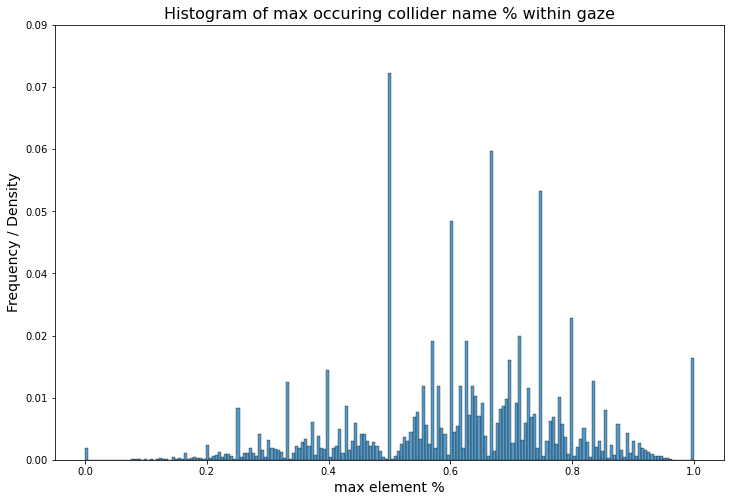

In [85]:

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax = sns.histplot(overview_df['MaxPercentage'])

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of max occuring collider name % within gaze', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


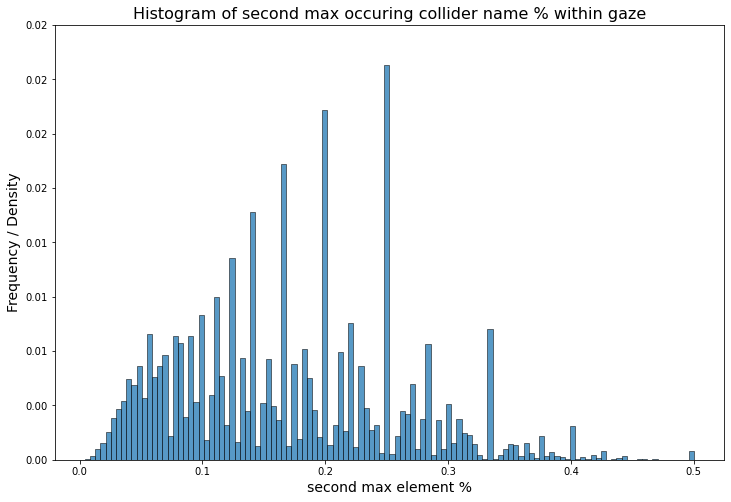

In [86]:
data2plot = overview_df['SecondMaxPercentage'].dropna()[overview_df['SecondMaxPercentage'] != 0]

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax = sns.histplot(data2plot)

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of second max occuring collider name % within gaze', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


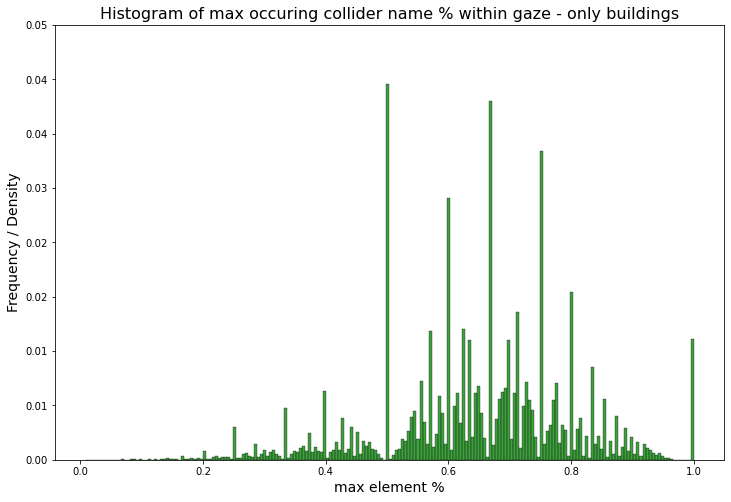

In [87]:
filtered_data = overview_df[overview_df['IsMaxNH'] == 0]['MaxPercentage']

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filtered_data, color = 'green')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of max occuring collider name % within gaze - only buildings', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


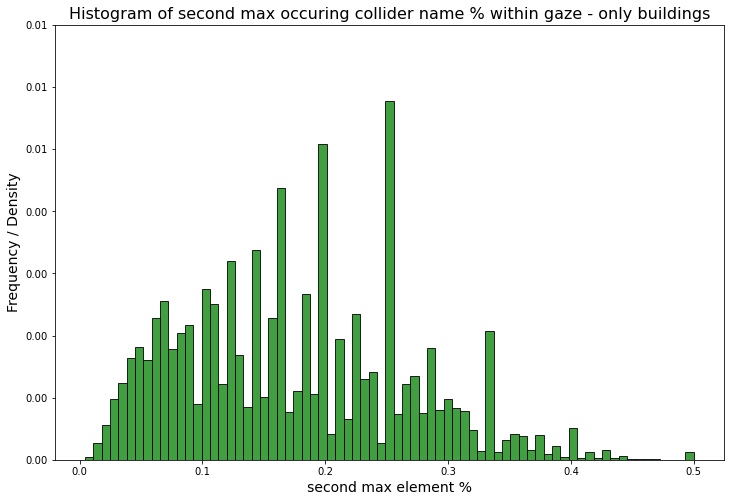

In [88]:
filtered_data = overview_df[(overview_df['IsSecondMaxNH'] == 0)]['SecondMaxPercentage']


# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax = sns.histplot(filtered_data, color = 'green')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of second max occuring collider name % within gaze - only buildings', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [62]:
overview_df['max12'] = overview_df['MaxPercentage'] + overview_df['SecondMaxPercentage']
overview_df['MaxPercentage_norm'] = overview_df['MaxPercentage']/ overview_df['max12']
overview_df['SecondMaxPercentage_norm'] = overview_df['SecondMaxPercentage']/ overview_df['max12']

overview_df.head()


,MaxName,MaxPercentage,IsMaxNH,SecondMaxName,SecondMaxPercentage,IsSecondMaxNH,HasNonStringValues,Participant,Session,FileIndex,max12,MaxPercentage_norm,SecondMaxPercentage_norm
0,pavement_O.002,0.818182,1.0,None,0.000000,NaN,False,1004,1,0,0.818182,1.000000,0.000000
1,pavement_O.002,0.571429,1.0,finger_middle_2_r,0.071429,1.0,False,1004,1,0,0.642857,0.888889,0.111111
2,terrain_O.001,0.789474,1.0,None,0.000000,NaN,False,1004,1,0,0.789474,1.000000,0.000000
3,Fence_34,0.260870,1.0,Body,0.086957,1.0,False,1004,1,0,0.347826,0.750000,0.250000
4,pavement_O.002,0.800000,1.0,None,0.000000,NaN,False,1004,1,0,0.800000,1.000000,0.000000


## now with normalized values

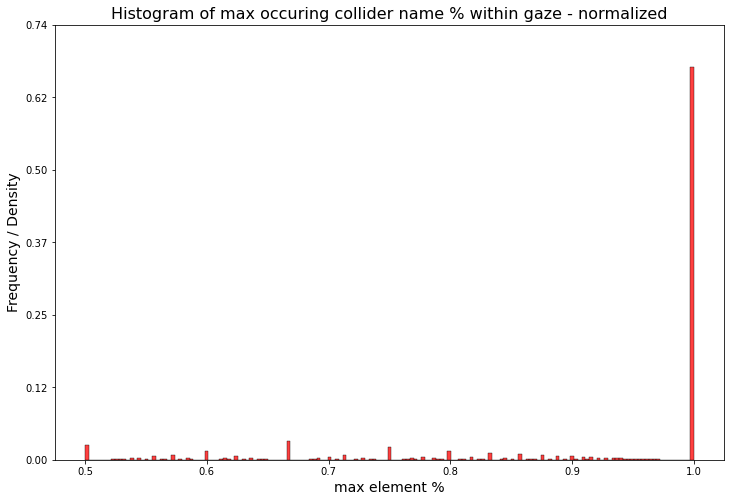

In [89]:

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax = sns.histplot(overview_df['MaxPercentage_norm'], color = 'red')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of max occuring collider name % within gaze - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


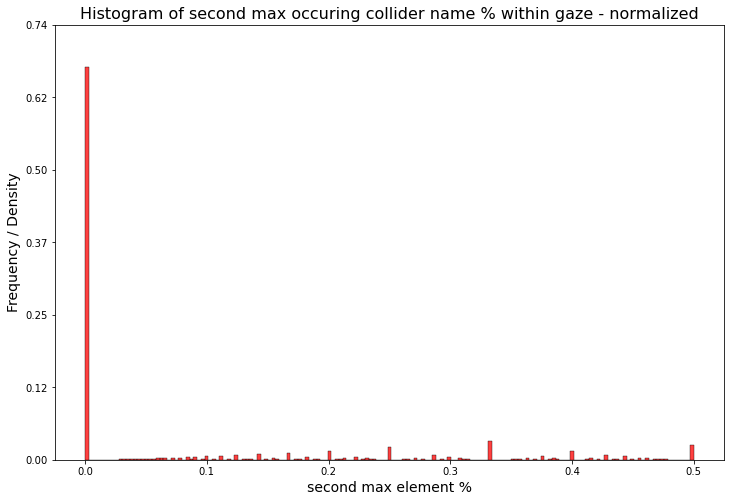

In [91]:
data2plot = overview_df['SecondMaxPercentage_norm'].dropna()

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax = sns.histplot(data2plot, color = 'red')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of second max occuring collider name % within gaze - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


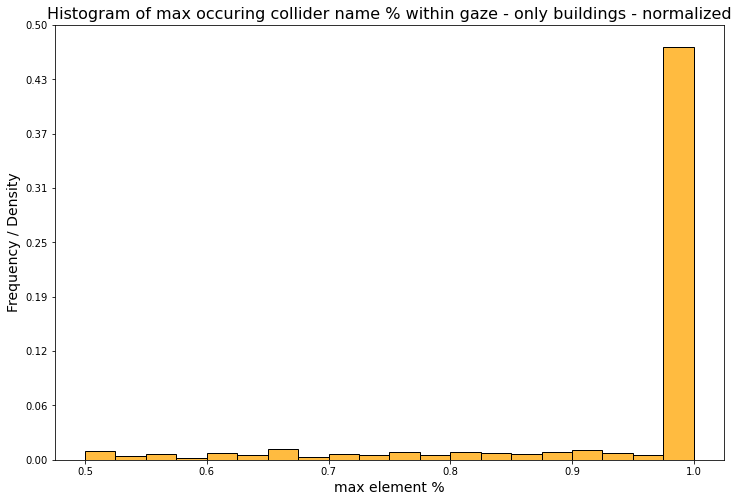

In [92]:
filtered_data = overview_df[overview_df['IsMaxNH'] == 0]['MaxPercentage_norm']

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filtered_data, color = 'orange')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])


# Add labels and title
plt.xlabel('max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of max occuring collider name % within gaze - only buildings - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


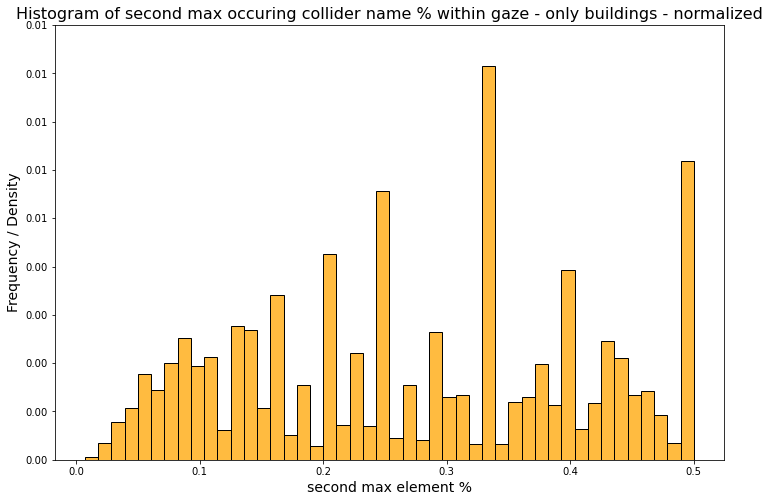

In [93]:
filtered_data = overview_df[(overview_df['IsSecondMaxNH'] == 0)]['SecondMaxPercentage_norm']


# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filtered_data, color = 'orange')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram of second max occuring collider name % within gaze - only buildings - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## check the data where the max element is NH and the second max is not

43128


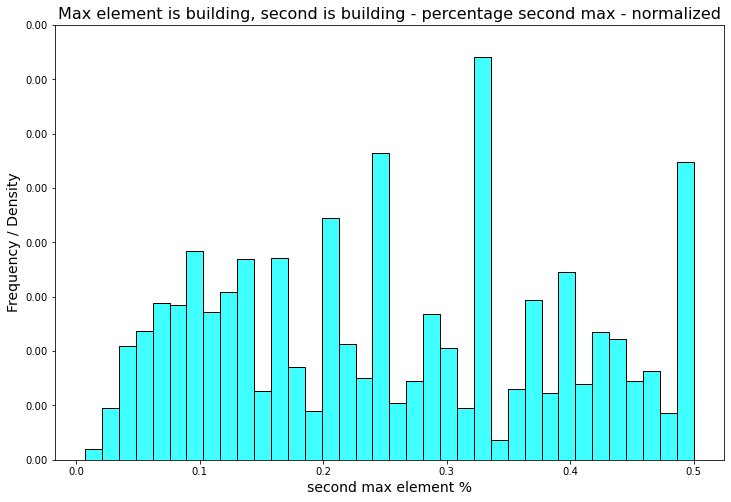

In [95]:
filtered_data = overview_df[(overview_df['IsMaxNH'] == 0) & (overview_df['IsSecondMaxNH'] == 0)]['SecondMaxPercentage_norm']

print(len(filtered_data))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filtered_data, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is building, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


40023


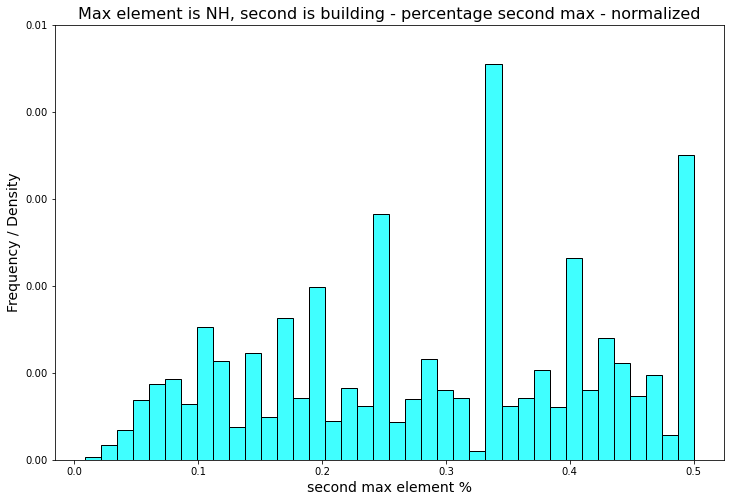

In [96]:
filtered_data = overview_df[(overview_df['IsMaxNH'] == 1) & (overview_df['IsSecondMaxNH'] == 0)]['SecondMaxPercentage_norm']

print(len(filtered_data))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filtered_data, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is NH, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [98]:
# Identify unique values in column 'A'


In [104]:
unique_NH_names_if2ndBuilding = overview_df[(overview_df['IsMaxNH'] == 1) & (overview_df['IsSecondMaxNH'] == 0)]['MaxName'].unique()

print(len(unique_NH_names_if2ndBuilding))
print(unique_NH_names_if2ndBuilding)

536
['CollisionObject1' 'Wall5' 'Cargo_container_v1_LD2close' 'Fence_22'
 'terrain_V.001' 'Hedge_2' 'Wheel03' 'Complete_fence.002'
 'pileOfClay_LOD0' 'scaffold_base_02_LOD0' 'Fence_4' 'Lamppost_v1 (2)'
 'Concrete_fence_v2_lattice_S' 'Cypress_v1_1' 'Body' 'SmallWall_15'
 'Wall_0' 'OldCityWall_16' 'CollisionObject0' 'SmallWall_13' 'Wall_1'
 'OldCityWall_13' 'pavement_Ha.002' 'terrain_H.001' 'Fence_37' 'Wall_2'
 'moss.001' 'OldCityWall_18' 'noHit' 'Wall' 'Bus_stop_v1' 'Cypress_v1_2'
 'OldCityWall_15' 'OldCityWall_21' 'OldCityWall_19'
 'road_base_network.004' 'OldCityWall_9' 'Fence' 'Complete_fence.001'
 'Hedge_7' 'pavement_F.004' 'Fence.001' 'OldCityWall_7' 'Cypress_v1_2 (4)'
 'Cypress_v1_2 (3)' 'Cypress_v1_2 (2)' 'Cypress_v1_1 (2)'
 'Euro_v7_3_Roof_floor' 'road.016' 'pavement_S.002' 'Fence_0'
 'CollisionObject2' 'pavement_E.008' 'SmallWall_44' 'terrain_E.001'
 'Wall_3' 'Lamppost_v1 (37)' 'terrain_S.001' 'Concrete_fence_v1_s2 (37)'
 'Concrete_fence_v1_s2 (35)' 'Lamppost_v1 (153)'
 'Concre

In [106]:
unique_building_names_if2ndBuilding = overview_df[(overview_df['IsMaxNH'] == 1) & (overview_df['IsSecondMaxNH'] == 0)]['SecondMaxName'].unique()

print(len(unique_building_names_if2ndBuilding ))


244


0.021005566382173702


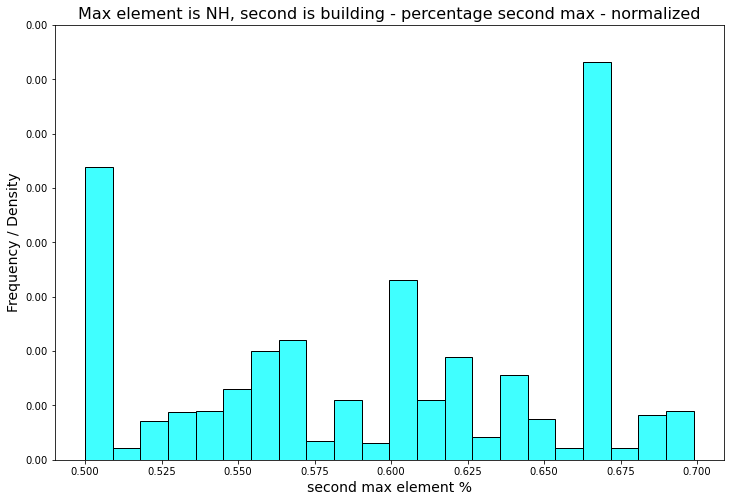

In [118]:
filteredData = overview_df[(overview_df['IsMaxNH'] == 0) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['MaxPercentage_norm']

print(len(filteredData)/len(overview_df))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filteredData, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is NH, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()




0.021005566382173702


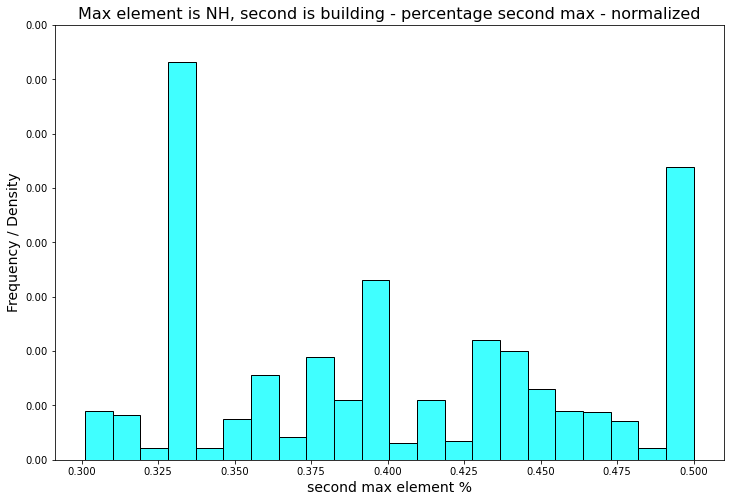

In [117]:
filteredData = overview_df[(overview_df['IsMaxNH'] == 0) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['SecondMaxPercentage_norm']



print(len(filteredData)/len(overview_df))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filteredData, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is NH, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()




In [121]:
# occurence of unique max 

maxName_filt = overview_df[(overview_df['IsMaxNH'] == 0) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['MaxName']


max2Name_filt = overview_df[(overview_df['IsMaxNH'] == 0) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['SecondMaxName']


print(len(maxName_filt.unique()))
print(len(max2Name_filt.unique()))

244
244


In [122]:
maxName_filt = overview_df[(overview_df['IsMaxNH'] == 1) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['MaxName']


max2Name_filt = overview_df[(overview_df['IsMaxNH'] == 1) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['SecondMaxName']


print(len(maxName_filt.unique()))
print(len(max2Name_filt.unique()))

504
244


0.024187064139143448


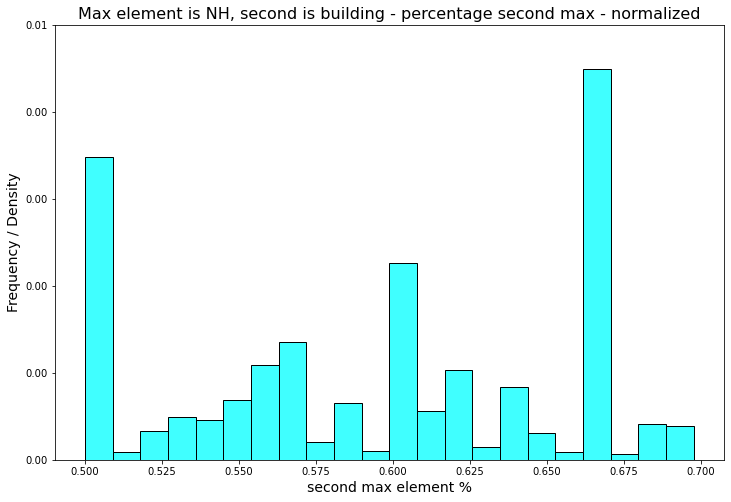

In [123]:
filteredData = overview_df[(overview_df['IsMaxNH'] == 1) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['MaxPercentage_norm']

print(len(filteredData)/len(overview_df))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filteredData, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is NH, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()




0.024187064139143448


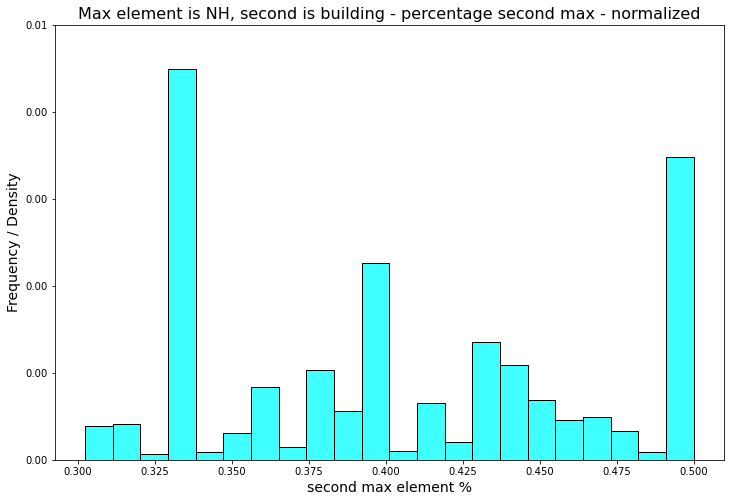

In [124]:
filteredData = overview_df[(overview_df['IsMaxNH'] == 1) 
                                            & (overview_df['IsSecondMaxNH'] == 0) 
                                            & (overview_df['MaxPercentage_norm'] < 0.7)  
                                            & (overview_df['SecondMaxPercentage_norm'] > 0.3)]['SecondMaxPercentage_norm']



print(len(filteredData)/len(overview_df))

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
ax= sns.histplot(filteredData, color = 'cyan')

# Convert y-axis labels to percentage of the total data length
total_data_length = len(overview_df)
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # Make sure we include the correct points for y-ticks
ax.set_yticklabels(['{:.2f}'.format(y / total_data_length) for y in y_ticks])

# Add labels and title
plt.xlabel('second max element %', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Max element is NH, second is building - percentage second max - normalized', fontsize=16)

# Save the figure
# savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
# plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()




In [101]:
overview_df.head()

,MaxName,MaxPercentage,IsMaxNH,SecondMaxName,SecondMaxPercentage,IsSecondMaxNH,HasNonStringValues,Participant,Session,FileIndex,max12,MaxPercentage_norm,SecondMaxPercentage_norm
0,pavement_O.002,0.818182,1.0,None,0.000000,NaN,False,1004,1,0,0.818182,1.000000,0.000000
1,pavement_O.002,0.571429,1.0,finger_middle_2_r,0.071429,1.0,False,1004,1,0,0.642857,0.888889,0.111111
2,terrain_O.001,0.789474,1.0,None,0.000000,NaN,False,1004,1,0,0.789474,1.000000,0.000000
3,Fence_34,0.260870,1.0,Body,0.086957,1.0,False,1004,1,0,0.347826,0.750000,0.250000
4,pavement_O.002,0.800000,1.0,None,0.000000,NaN,False,1004,1,0,0.800000,1.000000,0.000000


## check the occurances of expected data

In [130]:
print(len(overview_df[(overview_df['MaxPercentage'] > 0.8)])/len(overview_df))

print(len(overview_df[(overview_df['MaxPercentage_norm'] > 0.8)])/len(overview_df))


print(len(overview_df[(overview_df['MaxPercentage'] > 0.6)])/len(overview_df))

print(len(overview_df[(overview_df['MaxPercentage_norm'] > 0.6)])/len(overview_df))


0.1106846538572563
0.7795995128641285
0.5654641480635358
0.9234297239604692
